In [1]:
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])

import folium
from IPython.core.display import display, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pyspark.sql import *
from pyspark.sql.functions import *
import re
import scipy as sp
from scipy import stats
from scipy import sparse
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import random
from branca.colormap import LinearColormap

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

# Exploration and cleaning

We first handle the nutrition-related data.

In [2]:
food_facts = spark.read.csv('../data/raw/en.openfoodfacts.org.products.csv', header=True, sep="\t")
food_facts.registerTempTable('food_facts')

In [3]:
food_facts.printSchema()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable 

### First exploration of the data

In [4]:
number_of_products = food_facts.count()
print("We have {} products in our dataframe.".format(number_of_products))

We have 699124 products in our dataframe.


In [5]:
print("Number of distinct city tags without france: {}".format(
    food_facts.select('cities_tags').filter('cities_tags NOT LIKE "%france%"')
    .distinct().count())
)
print("Number of distinct city tags : {}".format(
    food_facts.select('cities_tags').distinct().count())
)

Number of distinct city tags without france: 3
Number of distinct city tags : 3332


In [6]:
print("Number of distinct purchase places without france in the name: {}".format(
    food_facts.select('purchase_places').filter('LOWER(purchase_places) NOT LIKE "%france%"')
    .distinct().count()))
print("Number of distinct purchase places : {}".format(
    food_facts.select('purchase_places').distinct().count()))

Number of distinct purchase places without france in the name: 3480
Number of distinct purchase places : 7822


In [7]:
print("Number of manufacturing places without france in the name: {}".format(
    food_facts.select('manufacturing_places_tags')
              .filter('LOWER(manufacturing_places_tags) NOT LIKE "%france%"')
              .distinct().count())
)
print("Number of manufacturing places : {}".format(
    food_facts.select('manufacturing_places_tags').distinct().count())
)

Number of manufacturing places without france in the name: 7673
Number of manufacturing places : 12080


It seems more interesting to make an analysis focused on the French situation rather than the situation in the US.

In [8]:
food_facts.select('generic_name').filter('generic_name IS NOT NULL') \
    .distinct().toPandas().head()

generic_name
0                 Banana & Berries - Banane et baies
1                        Boisson au jus de cranberry
2     Bebida de almendras UHT con calcio y vitaminas
3                   Cereal de maiz inflado endulzado
4  Base en pâte brisée avec du bœuf d'origine bri...

We'll probably have to filter out the names that are not present in French.

In [9]:
nutrition_grades = food_facts.select(
    'nutrition_grade_fr', 'nutrition_grade_uk', 'code', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'
    ).filter('nutrition_grade_fr IS NOT NULL OR nutrition_grade_uk IS NOT NULL OR `nutrition-score-uk_100g` IS NOT NULL OR `nutrition-score-fr_100g` IS NOT NULL').toPandas()
print("""Total number of products for which we have nutrition informations: 
{}"""
      .format(nutrition_grades.count())
)
print("Proportion of products for which we have nutrition informations: {ratio:.3%}"
      .format(ratio=(nutrition_grades['code'].count()/number_of_products))
)
print("Description of the table: ")
nutrition_grades.describe()

Total number of products for which we have nutrition informations: 
nutrition_grade_fr         141680
nutrition_grade_uk              0
code                       141680
nutrition-score-fr_100g    141680
nutrition-score-uk_100g    141680
dtype: int64
Proportion of products for which we have nutrition informations: 20.265%
Description of the table: 


nutrition_grade_fr  nutrition_grade_uk           code  \
count              141680                 0.0         141680   
unique                  5                 0.0         141676   
top                     d                 NaN  3263851538918   
freq                41275                 NaN              2   

       nutrition-score-fr_100g nutrition-score-uk_100g  
count                   141680                  141680  
unique                      56                      56  
top                          0                       0  
freq                      7380                   10207

We see that `nutrition_grade_uk` is useless.

## Data cleaning

## Food

In [10]:
# select only the columns we plan to use
food_dataframe = food_facts.select('generic_name',
                                   'code',
                                   'nutrition_grade_fr',
                                   'nutrition-score-fr_100g',
                                   'nutrition-score-uk_100g',
                                   'serving_size',
                                   'energy_100g',
                                   'energy-from-fat_100g', 
                                   'trans-fat_100g',
                                   'fat_100g',
                                   'saturated-fat_100g',
                                   'monounsaturated-fat_100g',
                                   'polyunsaturated-fat_100g',
                                   'cholesterol_100g',
                                   'proteins_100g',
                                   'carbohydrates_100g', 
                                   'sugars_100g', 
                                   'fiber_100g',
                                   'fruits-vegetables-nuts_100g',
                                   'fruits-vegetables-nuts-estimate_100g',
                                   'glycemic-index_100g',
                                   'cities',
                                   'cities_tags',
                                   'purchase_places',
                                   'stores',
                                   'countries',
                                   'countries_tags')
# move to pandas for the rest of the analysis
food_dataframe = food_dataframe.toPandas()

We first remove all products that are not sold in France.

In [11]:
food_dataframe = food_dataframe[np.logical_not(food_dataframe['countries_tags'].apply(
                                        lambda x: x is None or "france" not in x.lower())
               & food_dataframe['countries'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['cities_tags'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['cities'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['purchase_places'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['stores'].apply(lambda x: x is None or "france" not in x.lower()))]

Now, we want to check how many of our features have a significant amount of entries.

In [12]:
total_rows = len(food_dataframe)
for col in food_dataframe.columns:
    none_values = np.count_nonzero(food_dataframe[col].apply(lambda x: x is None))
    not_none_percentage = (total_rows - none_values) / total_rows
    print('Rows that are **not** None in {col}: {p:.3%}'.format(col=col, p=not_none_percentage))

Rows that are **not** None in generic_name: 12.453%
Rows that are **not** None in code: 100.000%
Rows that are **not** None in nutrition_grade_fr: 26.243%
Rows that are **not** None in nutrition-score-fr_100g: 26.243%
Rows that are **not** None in nutrition-score-uk_100g: 26.243%
Rows that are **not** None in serving_size: 11.005%
Rows that are **not** None in energy_100g: 86.242%
Rows that are **not** None in energy-from-fat_100g: 0.025%
Rows that are **not** None in trans-fat_100g: 0.308%
Rows that are **not** None in fat_100g: 85.178%
Rows that are **not** None in saturated-fat_100g: 85.903%
Rows that are **not** None in monounsaturated-fat_100g: 0.429%
Rows that are **not** None in polyunsaturated-fat_100g: 0.435%
Rows that are **not** None in cholesterol_100g: 0.302%
Rows that are **not** None in proteins_100g: 86.176%
Rows that are **not** None in carbohydrates_100g: 85.112%
Rows that are **not** None in sugars_100g: 85.929%
Rows that are **not** None in fiber_100g: 25.204%
Rows 

**Based on this, we will have to remove some rows:**

We remove the rows for which we have less than 10% of not None values.

- energy-from-fat_100g
- monounsaturated-fat_100g
- polyunsaturated-fat_100g
- cholesterol_100g
- trans-fat_100g
- fruits-vegetables-nuts_100g
- fruits-vegetables-nuts-estimate_100g
- glycemic-index_100g
- cities
- generic_name

Since we have the code of the product, we drop the generic_name attribute too.

We also need to drop all rows for which we have no information whatsoever (nutrition_grade, fat, saturated fat, sugars, proteins, fiber, carbohydrates, energy).

Finally, we need to drop all rows for which we have no information on the city where it is sold.

In [13]:
# drop the columns with too few values
food_dataframe = food_dataframe.drop(columns=['energy-from-fat_100g', 
                             'monounsaturated-fat_100g', 
                             'polyunsaturated-fat_100g',
                             'cholesterol_100g',
                             'trans-fat_100g',
                             'fruits-vegetables-nuts_100g',
                             'fruits-vegetables-nuts-estimate_100g',
                             'glycemic-index_100g',
                             'glycemic-index_100g',
                             'cities',
                             'generic_name'])

# drop the rows with too little nutritional information
food_dataframe = food_dataframe[np.logical_not(food_dataframe['nutrition_grade_fr'].apply(lambda x: x is None)
                                               # we do not check the values of nutrition-score-fr_100g or
                                               # nutrition-score-uk_100g, because we know that they exists for exactly
                                               # the same rows as nutrition_grade_fr
                                               & food_dataframe['energy_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['fat_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['saturated-fat_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['carbohydrates_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['sugars_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['fiber_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['proteins_100g'].apply(lambda x: x is None)
                                              )
                               ]

# drop the rows with no purchase place
food_dataframe = food_dataframe[food_dataframe['purchase_places'].apply(lambda x: x is not None)]

In [14]:
food_dataframe.head()

code nutrition_grade_fr nutrition-score-fr_100g  \
108  0000000020114               None                    None   
254  0000000274722                  b                       0   
255  0000000274739                  b                       1   
292  0000007020254                  e                      12   
302  0000009125124                  b                       1   

    nutrition-score-uk_100g         serving_size energy_100g fat_100g  \
108                    None                16 ml           0        0   
254                       0                285 g         450      2.2   
255                       1                300 g         455      4.2   
292                       4                33 cl         213        0   
302                       1  40 g + 100 ml d'eau        1577      0.5   

    saturated-fat_100g proteins_100g carbohydrates_100g sugars_100g  \
108                  0             0                  0           0   
254                0.9           6.8               15.3         0.5   
255                2.1           4.4               12.5         1.4   
292                  0             0                 14           0   
302                0.1           1.5                 93          66   

    fiber_100g cities_tags    purchase_places        stores  \
108       None        None             France          None   
254        0.5        None             France  Comme J'aime   
255        1.8        None             France          None   
292          0        None  France,États-Unis          None   
302       None        None             France          None   

             countries              countries_tags  
108          en:france                   en:france  
254             France                   en:france  
255             France                   en:france  
292  France,États-Unis  en:france,en:united-states  
302             France                   en:france

In [15]:
total_rows = len(food_dataframe)
for col in list(food_dataframe.columns):
    none_values = np.count_nonzero(food_dataframe[col].apply(lambda x: x is None))
    not_none_percentage = (total_rows - none_values) / total_rows
    print('Rows that are **not** None in {col}: {p:.3%}'.format(col=col, p=not_none_percentage))

Rows that are **not** None in code: 100.000%
Rows that are **not** None in nutrition_grade_fr: 89.747%
Rows that are **not** None in nutrition-score-fr_100g: 89.747%
Rows that are **not** None in nutrition-score-uk_100g: 89.747%
Rows that are **not** None in serving_size: 49.843%
Rows that are **not** None in energy_100g: 99.508%
Rows that are **not** None in fat_100g: 99.086%
Rows that are **not** None in saturated-fat_100g: 98.003%
Rows that are **not** None in proteins_100g: 99.243%
Rows that are **not** None in carbohydrates_100g: 98.726%
Rows that are **not** None in sugars_100g: 98.081%
Rows that are **not** None in fiber_100g: 54.563%
Rows that are **not** None in cities_tags: 30.393%
Rows that are **not** None in purchase_places: 100.000%
Rows that are **not** None in stores: 75.573%
Rows that are **not** None in countries: 99.980%
Rows that are **not** None in countries_tags: 99.980%


We still have rows for which the city tag is none and the purchase place is very vague, like France or the US. We need to take care of those. We will do it by creating a matching between the Open Food Facts dataset and a dataset including all cities of France.

## Cities

In [16]:
# The dataframe: 
# https://www.insee.fr/fr/statistiques/3126432
revenue_df = pd.read_excel("../data/raw/base-cc-filosofi-2014.xls", skiprows=[0,1,2,3])

# Drop rows that are not data and reset index
revenue_df.drop(0, inplace=True)
revenue_df.reset_index(inplace=True, drop=True)


# Drop useless columns
revenue_df = revenue_df.drop(columns=['Nombre de ménages fiscaux','Code géographique',
                                      'dont part des salaires, traitements ou chômage (%)',
                                      "dont part des revenus d'activités non salariées (%)",
                                      'dont part des prestations familiales (%)',
                                      'dont part des minima sociaux (%)',
                                      'dont part des prestations logement (%)',
                                      '1er décile du niveau de vie (€)',
                                      '9e décile du niveau de vie (€)',
                                      'Rapport inter-décile 9e décile/1er decile',
                                      'Part des ménages fiscaux imposés (%)'
                                     ]
                            )

# Translate the remaining columns to English
revenue_df = revenue_df.rename(columns={"ANNEE" : "Year",
                                        'Nombre de personnes dans les ménages fiscaux': "Household inhabitants", 
                                        'Médiane du niveau vie (€)': "Median revenue euros", 
                                        'Taux de pauvreté-Ensemble (%)' : "Total poverty rate (%)", 
                                        'Taux de pauvreté-moins de 30 ans (%)' : "Poverty rate (-30) (%)",
                                        'Taux de pauvreté-30 à 39 ans  (%)' : "Poverty rate (30-39) (%)",
                                        'Taux de pauvreté-40 à 49 ans (%)': "Poverty rate (40-49) (%)", 
                                        "Taux de pauvreté-50 à 59 ans (%)" :  "Poverty rate (50-59) (%)", 
                                        "Taux de pauvreté-60 à 74 ans (%)" :  "Poverty rate (60-74) (%)", 
                                        "Taux de pauvreté-75 ans ou plus (%)":  "Poverty rate (75+) (%)", 
                                        "Taux de pauvreté-propriétaires (%)" :  "Poverty rate (house owners) (%)", 
                                        "Taux de pauvreté-locataires (%)" :  "Poverty rate (tenants) (%)",
                                        "Part des revenus d'activité (%)" :  "Share of activity revenue (%)", 
                                        'Part des pensions, retraites et rentes (%)' :  "Share of retreat pension revenue (%)", 
                                        'Part des revenus du patrimoine et autres revenus (%)' :  "Share of heritage revenue and other (%)",  
                                        "Part de l'ensemble des prestations sociales (%)" :  "Share of social benefits revenue (%)", 
                                        'Part des impôts (%)' :  "Share of taxes (%)",
                                        'Libellé géographique' : "City name"
                                       }
                              )

In [17]:
revenue_df.head()

City name Household inhabitants Median revenue euros  \
0  L'Abergement-Clémenciat                 799.5              21576.7   
1    L'Abergement-de-Varey                 235.5              21672.9   
2        Ambérieu-en-Bugey               13660.5              19756.1   
3      Ambérieux-en-Dombes                1661.5              23204.8   
4                  Ambléon                   102              22157.5   

  Total poverty rate (%) Poverty rate (-30) (%) Poverty rate (30-39) (%)  \
0                    NaN                    NaN                      NaN   
1                    NaN                    NaN                      NaN   
2                15.7534                19.4181                  19.5204   
3                    NaN                    NaN                      NaN   
4                    NaN                    NaN                      NaN   

  Poverty rate (40-49) (%) Poverty rate (50-59) (%) Poverty rate (60-74) (%)  \
0                      NaN                      NaN                      NaN   
1                      NaN                      NaN                      NaN   
2                  19.1982                  14.7159                      NaN   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   

  Poverty rate (75+) (%) Poverty rate (house owners) (%)  \
0                    NaN                             NaN   
1                    NaN                             NaN   
2                    NaN                         5.40116   
3                    NaN                             NaN   
4                    NaN                             NaN   

  Poverty rate (tenants) (%) Share of activity revenue (%)  \
0                        NaN                           NaN   
1                        NaN                           NaN   
2                     24.796                          71.8   
3                        NaN                           NaN   
4                        NaN                           NaN   

  Share of retreat pension revenue (%)  \
0                                  NaN   
1                                  NaN   
2                                 27.3   
3                                  NaN   
4                                  NaN   

  Share of heritage revenue and other (%)  \
0                                     NaN   
1                                     NaN   
2                                    10.1   
3                                     NaN   
4                                     NaN   

  Share of social benefits revenue (%) Share of taxes (%)  
0                                  NaN                NaN  
1                                  NaN                NaN  
2                                  6.5              -15.7  
3                                  NaN                NaN  
4                                  NaN                NaN

In [18]:
print("Total number of rows:", len(revenue_df))

Total number of rows: 36621


In [19]:
print("Total number of cities: ", len(list(set(revenue_df["City name"]))))

Total number of cities:  34099


## Mapping cities - food products

In this section, we will try to find a mapping between a city as present in the OpenFoodFacts dataset, and a city as know by the INSEE.

In [20]:
# Helper to remove the accents
import unicodedata as ud

def remove_accents(input_str):
    nkfd_form = ud.normalize('NFKD', str(input_str))
    return u"".join([c for c in nkfd_form if not ud.combining(c)])

In [21]:
# First, let us remove the accents, lowercase everything, and replace apostrophes by carets
revenue_df['City name'] = revenue_df['City name'].apply(lambda x: remove_accents(x.lower().replace("'", "-"))) 


In [22]:
revenue_df.head()

City name Household inhabitants Median revenue euros  \
0  l-abergement-clemenciat                 799.5              21576.7   
1    l-abergement-de-varey                 235.5              21672.9   
2        amberieu-en-bugey               13660.5              19756.1   
3      amberieux-en-dombes                1661.5              23204.8   
4                  ambleon                   102              22157.5   

  Total poverty rate (%) Poverty rate (-30) (%) Poverty rate (30-39) (%)  \
0                    NaN                    NaN                      NaN   
1                    NaN                    NaN                      NaN   
2                15.7534                19.4181                  19.5204   
3                    NaN                    NaN                      NaN   
4                    NaN                    NaN                      NaN   

  Poverty rate (40-49) (%) Poverty rate (50-59) (%) Poverty rate (60-74) (%)  \
0                      NaN                      NaN                      NaN   
1                      NaN                      NaN                      NaN   
2                  19.1982                  14.7159                      NaN   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   

  Poverty rate (75+) (%) Poverty rate (house owners) (%)  \
0                    NaN                             NaN   
1                    NaN                             NaN   
2                    NaN                         5.40116   
3                    NaN                             NaN   
4                    NaN                             NaN   

  Poverty rate (tenants) (%) Share of activity revenue (%)  \
0                        NaN                           NaN   
1                        NaN                           NaN   
2                     24.796                          71.8   
3                        NaN                           NaN   
4                        NaN                           NaN   

  Share of retreat pension revenue (%)  \
0                                  NaN   
1                                  NaN   
2                                 27.3   
3                                  NaN   
4                                  NaN   

  Share of heritage revenue and other (%)  \
0                                     NaN   
1                                     NaN   
2                                    10.1   
3                                     NaN   
4                                     NaN   

  Share of social benefits revenue (%) Share of taxes (%)  
0                                  NaN                NaN  
1                                  NaN                NaN  
2                                  6.5              -15.7  
3                                  NaN                NaN  
4                                  NaN                NaN

In [23]:
# get the tags of the cities per food item:
# until now, the tags were a comma separated list of tags
# we first split them
cities_for_food = (food_dataframe['cities_tags'].str.split(',', expand=True)
                    # then we create one entry per couple (food item, city tag)
                    .stack()
                    # we remove the index, as we will need to keep the column containing the id of the food item
                    .reset_index()
                    # and we drop duplicates and unnecessary columns
                    .drop(columns='level_1').drop_duplicates())

In [24]:
# we move back to spark, because pandas is too weak
sdf_city_names = spark.createDataFrame(revenue_df['City name'].drop_duplicates().reset_index())
sdf_cities_for_food = spark.createDataFrame(cities_for_food)
sdf_cities_for_food.createTempView('cities_for_food')
sdf_city_names.createTempView('city_names')

In [25]:
# we join our two dataframes, explanation below
sdf_joined = spark.sql("""
SELECT city_names.index AS city_index, city_names.`City name` AS city_name, 
       aux.food_item_index, aux.city_tag_from_food_item
FROM city_names
JOIN (
    SELECT MAX(LENGTH(city_names.`City name`)) AS length_city_name, 
           cities_for_food.level_0 AS food_item_index, cities_for_food.`0` AS city_tag_from_food_item
    FROM cities_for_food
    JOIN city_names
    ON cities_for_food.`0` LIKE CONCAT(city_names.`City name`, '%')
    GROUP BY cities_for_food.level_0, cities_for_food.`0`
) AS aux
ON aux.city_tag_from_food_item LIKE CONCAT(city_names.`City name`, '%')
WHERE aux.length_city_name == LENGTH(city_names.`City name`)
""")

A city's tag seems to usually be 'city-s-name-department-name-country-name'.
A city's name is now 'city-s-name'.

Thus we can join on the condition: `city_s_tag LIKE city_s_name + '%'`.

Unfortunately, the city's name "Saint Alban", formatted as "saint-alban", will also match the tag "saint-alban-les-eaux", though these two cities maybe totally different and far away from one another.

Thus, we want to kep only the longest city's name matching the tag, hence:
```sql
SELECT MAX(LENGTH(city_names.`City name`)) AS length_city_name, 
           cities_for_food.level_0 AS food_item_index, cities_for_food.`0` AS city_tag_from_food_item
    FROM cities_for_food
    JOIN city_names
    ON cities_for_food.`0` LIKE CONCAT(city_names.`City name`, '%')
    GROUP BY cities_for_food.level_0, cities_for_food.`0`
```
returning the size of the longest matching city name.

We then have to re-do the same join and filter using the computed condition.

In [26]:
# we write our dataframe to parquet, to be able to reuse it without needing to recompute everything
sdf_joined.write.mode('overwrite').parquet("../data/interim/sdf_joined_city_names.parquet")

In [27]:
# now we still have to join our food items and our cities, using the mapping we managed to get above
# we switch back to pandas
pdf_joined = sdf_joined.toPandas()
pdf_joined.head()

city_index                     city_name  food_item_index  \
0        4315  sainte-genevieve-sur-argence           473948   
1        4315  sainte-genevieve-sur-argence           670213   
2        4315  sainte-genevieve-sur-argence           439198   
3        4315  sainte-genevieve-sur-argence           473957   
4        4315  sainte-genevieve-sur-argence           473954   

                       city_tag_from_food_item  
0  sainte-genevieve-sur-argence-aveyron-france  
1  sainte-genevieve-sur-argence-aveyron-france  
2  sainte-genevieve-sur-argence-aveyron-france  
3  sainte-genevieve-sur-argence-aveyron-france  
4  sainte-genevieve-sur-argence-aveyron-france

In [28]:
# we join our mapping with the food dataframe
food_df_for_join = pdf_joined.join(food_dataframe, on="food_item_index")
food_df_for_join.head()

city_index                     city_name  food_item_index  \
0        4315  sainte-genevieve-sur-argence           473948   
1        4315  sainte-genevieve-sur-argence           670213   
2        4315  sainte-genevieve-sur-argence           439198   
3        4315  sainte-genevieve-sur-argence           473957   
4        4315  sainte-genevieve-sur-argence           473954   

                       city_tag_from_food_item           code  \
0  sainte-genevieve-sur-argence-aveyron-france  3760087842005   
1  sainte-genevieve-sur-argence-aveyron-france  8480017474278   
2  sainte-genevieve-sur-argence-aveyron-france  3596710349302   
3  sainte-genevieve-sur-argence-aveyron-france  3760087843231   
4  sainte-genevieve-sur-argence-aveyron-france  3760087843019   

  nutrition_grade_fr nutrition-score-fr_100g nutrition-score-uk_100g  \
0                  c                       3                       3   
1               None                    None                    None   
2                  c                       4                       4   
3                  b                       2                       2   
4                  d                      11                      11   

  serving_size energy_100g      ...       saturated-fat_100g proteins_100g  \
0         None         837      ...                      5.4          13.5   
1         None        1029      ...                     None            17   
2        100 g         891      ...                      7.2            19   
3        180 g         883      ...                      5.9          19.1   
4         None        1029      ...                      8.6            17   

  carbohydrates_100g sugars_100g fiber_100g  \
0                1.5         1.5          2   
1                  0        None       None   
2                0.5         0.5          0   
3                  0           0       None   
4                  0           0       None   

                                         cities_tags  \
0  sainte-genevieve-sur-argence-aveyron-france,sa...   
1        sainte-genevieve-sur-argence-aveyron-france   
2        sainte-genevieve-sur-argence-aveyron-france   
3  sainte-genevieve-sur-argence-aveyron-france,sa...   
4  sainte-genevieve-sur-argence-aveyron-france,sa...   

                             purchase_places                stores  countries  \
0                 Flers-en-Escrebieux,France             Carrefour  en:france   
1  Rillieux-la-Pape,Rhône,Rhône-ALpes,France                   Dia     France   
2                          Strasbourg,France  Simply,Simply Market     France   
3                                     France                  None     France   
4                              France,Harnes         Simply Market     France   

  countries_tags  
0      en:france  
1      en:france  
2      en:france  
3      en:france  
4      en:france  

[5 rows x 21 columns]

In [29]:
# we join again on the income dataframe
global_df = food_df_for_join.join(revenue_df, on="city_index")
# we can now drop the intermediary columns: city_name, and cities_tags
global_df.drop(columns=['cities_tags'], inplace=True)
global_df.head()

city_index                     city_name  food_item_index  \
0        4315  sainte-genevieve-sur-argence           473948   
1        4315  sainte-genevieve-sur-argence           670213   
2        4315  sainte-genevieve-sur-argence           439198   
3        4315  sainte-genevieve-sur-argence           473957   
4        4315  sainte-genevieve-sur-argence           473954   

                       city_tag_from_food_item           code  \
0  sainte-genevieve-sur-argence-aveyron-france  3760087842005   
1  sainte-genevieve-sur-argence-aveyron-france  8480017474278   
2  sainte-genevieve-sur-argence-aveyron-france  3596710349302   
3  sainte-genevieve-sur-argence-aveyron-france  3760087843231   
4  sainte-genevieve-sur-argence-aveyron-france  3760087843019   

  nutrition_grade_fr nutrition-score-fr_100g nutrition-score-uk_100g  \
0                  c                       3                       3   
1               None                    None                    None   
2                  c                       4                       4   
3                  b                       2                       2   
4                  d                      11                      11   

  serving_size energy_100g        ...         Poverty rate (50-59) (%)  \
0         None         837        ...                              NaN   
1         None        1029        ...                              NaN   
2        100 g         891        ...                              NaN   
3        180 g         883        ...                              NaN   
4         None        1029        ...                              NaN   

  Poverty rate (60-74) (%) Poverty rate (75+) (%)  \
0                      NaN                    NaN   
1                      NaN                    NaN   
2                      NaN                    NaN   
3                      NaN                    NaN   
4                      NaN                    NaN   

  Poverty rate (house owners) (%) Poverty rate (tenants) (%)  \
0                             NaN                        NaN   
1                             NaN                        NaN   
2                             NaN                        NaN   
3                             NaN                        NaN   
4                             NaN                        NaN   

  Share of activity revenue (%) Share of retreat pension revenue (%)  \
0                           NaN                                  NaN   
1                           NaN                                  NaN   
2                           NaN                                  NaN   
3                           NaN                                  NaN   
4                           NaN                                  NaN   

  Share of heritage revenue and other (%)  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Share of social benefits revenue (%) Share of taxes (%)  
0                                  NaN                NaN  
1                                  NaN                NaN  
2                                  NaN                NaN  
3                                  NaN                NaN  
4                                  NaN                NaN  

[5 rows x 37 columns]

In [30]:
# we cannot use the nutrition_grade as is. Thus we turn it into a numerical value
def grade_to_number(x):
    if x == "a":
        return 1
    if x == "b":
        return 2
    if x == "c":
        return 3
    if x == "d":
        return 4
    if x == "e":
        return 5
    return 0
global_df['nutrition_grade_numeric'] = global_df['nutrition_grade_fr'].apply(grade_to_number).astype('int')

In [31]:
global_df.to_csv("../data/interim/clean_food_and_cities.csv")

**DISCLAIMER:** Several French towns have the exact same name. Thus, we have a few errors in our mapping. As this situation concerns less than 1% of the towns, it shouldn't impact our analysis.

## Arrondissements

In order to visualize data, we need to make the correspondences between the cities that we have and their respective arrondissement. The arrondissement is the territorial subdivision of the French territory that comes after the Département. There are around 340 arrondissements in France. We thought this subdivision was small enough to show the differences across the French territory but large enough for it to be visible on a map. In the same step, we kept the information relative to the other administrative areas in France, namely the departments and regions.

In [32]:
global_df = pd.read_csv('../data/interim/clean_food_and_cities.csv')

In [33]:
# The new dataframe:
# https://www.insee.fr/fr/information/2028028
# Table d'appartenance géographique des communes au 1ᵉʳ janvier 2017
city_arr = pd.read_excel('../data/raw/table-appartenance-geo-communes-17.xls', skiprows=[0,1,2,3])
city_arr.drop(0, inplace=True)
city_arr.reset_index(inplace=True, drop=True)

city_arr["city_name"] = city_arr['Libellé géographique'].apply(
    # Remove accents, lowercase, and replace spaces ad apostrophes by '-'
    lambda x: remove_accents(x.lower().replace("'", '-').replace(" ", "-"))
) 

# Drop useless columns
city_arr = city_arr.drop(columns=['Intercommunalité - Métropole', "Nature d'EPCI", "Zone d'emploi 2010", 
                       "Unité urbaine 2010", "Tranche d'unité urbaine 2014", 
                       "Tranche détaillée d'unité urbaine 2014", "Aire urbaine 2010", 
                       "Tranche d'aire urbaine 2014", "Bassin de vie 2012"]
             )
city_arr.rename(columns={'Libellé géographique' : 'City name'}, inplace=True)
city_arr.head()

Code géographique                City name Département Région  \
0             01001  L'Abergement-Clémenciat          01     84   
1             01002    L'Abergement-de-Varey          01     84   
2             01004        Ambérieu-en-Bugey          01     84   
3             01005      Ambérieux-en-Dombes          01     84   
4             01006                  Ambléon          01     84   

  Arrondissement Canton ville Catégorie commune dans aires urbaines  \
0            012         0108                                   120   
1            011         0101                                   112   
2            011         0101                                   112   
3            012         0122                                   112   
4            011         0104                                   300   

                 city_name  
0  l-abergement-clemenciat  
1    l-abergement-de-varey  
2        amberieu-en-bugey  
3      amberieux-en-dombes  
4                  ambleon

In [34]:
# to match the geojson file we found, we have to format the code of our arrondissements
city_arr["custom_arrondissement_code"] = city_arr["Département"] + "00" + city_arr['Arrondissement'].astype('str').apply(lambda x: x[-1])
city_arr.head()

Code géographique                City name Département Région  \
0             01001  L'Abergement-Clémenciat          01     84   
1             01002    L'Abergement-de-Varey          01     84   
2             01004        Ambérieu-en-Bugey          01     84   
3             01005      Ambérieux-en-Dombes          01     84   
4             01006                  Ambléon          01     84   

  Arrondissement Canton ville Catégorie commune dans aires urbaines  \
0            012         0108                                   120   
1            011         0101                                   112   
2            011         0101                                   112   
3            012         0122                                   112   
4            011         0104                                   300   

                 city_name custom_arrondissement_code  
0  l-abergement-clemenciat                      01002  
1    l-abergement-de-varey                      01001  
2        amberieu-en-bugey                      01001  
3      amberieux-en-dombes                      01002  
4                  ambleon                      01001

In [35]:
city_arr.to_csv("../data/interim/city_region_arrondissement.csv")

In [36]:
global_arrond = global_df.merge(city_arr, left_on="city_name", right_on="city_name", how='inner')
global_arrond.head()

Unnamed: 0  city_index                     city_name  food_item_index  \
0           5        8649  saint-barthelemy-de-bussiere           399027   
1           6        8649  saint-barthelemy-de-bussiere           399024   
2           7        8649  saint-barthelemy-de-bussiere           399014   
3           8        8649  saint-barthelemy-de-bussiere           399025   
4           9        8649  saint-barthelemy-de-bussiere           399017   

                        city_tag_from_food_item           code  \
0  saint-barthelemy-de-bussiere-dordogne-france  3449350002192   
1  saint-barthelemy-de-bussiere-dordogne-france  3449350001782   
2  saint-barthelemy-de-bussiere-dordogne-france  3449350000440   
3  saint-barthelemy-de-bussiere-dordogne-france  3449350001843   
4  saint-barthelemy-de-bussiere-dordogne-france  3449350000754   

  nutrition_grade_fr  nutrition-score-fr_100g  nutrition-score-uk_100g  \
0                  d                     16.0                     16.0   
1                  d                     15.0                     15.0   
2                  d                     15.0                     15.0   
3                  d                     16.0                     16.0   
4                  e                     24.0                     24.0   

       serving_size            ...              Share of taxes (%)  \
0  Une tranche 25 g            ...                             NaN   
1               NaN            ...                             NaN   
2               NaN            ...                             NaN   
3               NaN            ...                             NaN   
4               NaN            ...                             NaN   

   nutrition_grade_numeric  Code géographique                   City name_y  \
0                        4              24381  Saint-Barthélemy-de-Bussière   
1                        4              24381  Saint-Barthélemy-de-Bussière   
2                        4              24381  Saint-Barthélemy-de-Bussière   
3                        4              24381  Saint-Barthélemy-de-Bussière   
4                        5              24381  Saint-Barthélemy-de-Bussière   

   Département  Région  Arrondissement Canton ville  \
0           24      75             242         2413   
1           24      75             242         2413   
2           24      75             242         2413   
3           24      75             242         2413   
4           24      75             242         2413   

  Catégorie commune dans aires urbaines custom_arrondissement_code  
0                                   400                      24002  
1                                   400                      24002  
2                                   400                      24002  
3                                   400                      24002  
4                                   400                      24002  

[5 rows x 47 columns]

In [37]:
global_arrond = global_arrond.rename(columns={"Département" : "Department", "Région" : "Region", "City name_y": "City name"})
global_arrond = global_arrond[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g', 
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 
                       'fiber_100g', 'Median revenue euros', 'Total poverty rate (%)', 'Poverty rate (-30) (%)',
                       'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
                       'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
                       'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
                       'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
                       'Share of retreat pension revenue (%)',
                       'Share of heritage revenue and other (%)',
                       'Share of social benefits revenue (%)', 'Share of taxes (%)', 'City name', 
                       'Department', 'Region', 'custom_arrondissement_code', 'city_name', 'city_tag_from_food_item']]
global_arrond.head()

food_item_index  nutrition-score-fr_100g  nutrition-score-uk_100g  \
0           399027                     16.0                     16.0   
1           399024                     15.0                     15.0   
2           399014                     15.0                     15.0   
3           399025                     16.0                     16.0   
4           399017                     24.0                     24.0   

   nutrition_grade_numeric      serving_size  energy_100g  fat_100g  \
0                        4  Une tranche 25 g        962.0      12.4   
1                        4               NaN        816.0       9.1   
2                        4               NaN        816.0       9.1   
3                        4               NaN        964.0      12.4   
4                        5               NaN       1502.0      27.2   

   saturated-fat_100g  proteins_100g  carbohydrates_100g  \
0                 4.6           29.4                0.50   
1                 3.3           26.6                1.77   
2                 3.3           26.6                1.77   
3                 4.6           29.4                0.50   
4                10.4           26.0                2.50   

                       ...                       \
0                      ...                        
1                      ...                        
2                      ...                        
3                      ...                        
4                      ...                        

   Share of retreat pension revenue (%)  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   Share of heritage revenue and other (%)  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   Share of social benefits revenue (%)  Share of taxes (%)  \
0                                   NaN                 NaN   
1                                   NaN                 NaN   
2                                   NaN                 NaN   
3                                   NaN                 NaN   
4                                   NaN                 NaN   

                      City name  Department  Region  \
0  Saint-Barthélemy-de-Bussière          24      75   
1  Saint-Barthélemy-de-Bussière          24      75   
2  Saint-Barthélemy-de-Bussière          24      75   
3  Saint-Barthélemy-de-Bussière          24      75   
4  Saint-Barthélemy-de-Bussière          24      75   

   custom_arrondissement_code                     city_name  \
0                       24002  saint-barthelemy-de-bussiere   
1                       24002  saint-barthelemy-de-bussiere   
2                       24002  saint-barthelemy-de-bussiere   
3                       24002  saint-barthelemy-de-bussiere   
4                       24002  saint-barthelemy-de-bussiere   

                        city_tag_from_food_item  
0  saint-barthelemy-de-bussiere-dordogne-france  
1  saint-barthelemy-de-bussiere-dordogne-france  
2  saint-barthelemy-de-bussiere-dordogne-france  
3  saint-barthelemy-de-bussiere-dordogne-france  
4  saint-barthelemy-de-bussiere-dordogne-france  

[5 rows x 33 columns]

In [38]:
global_arrond.to_csv("../data/interim/clean_food_cities_arrond.csv")

# Analysis of our data

Our aim is to explore the relations that exist between the social and economic status of the French population and the quality of the food that is available. 

Indeed, we start from a point where we believe there is a correlation between obesity and socio-economic level: poor people tend to be more overweight than their richer counterparts. Moreover, obesity has been linked with the consumption of food items that have high rates of sugar, fat and energy.

We wish to explore a possible intermediate link between obesity and socio-economic level: the quality of the available food. 

Our dataframe includes labelled products, their nutritional information, a few nutritional scores and the places where these products are sold. We have coupled this data with economical and social data from French cities in order to obtain a clean dataframe containing for each row:
- a product identifier
- its nutritional information
- the city where it is sold (if sold in several cities, the row is duplicated)
- the median revenue, mean revenue, poverty rate and other economic features relative to the city

In order to analyse our data, we have proceeded in several steps:

1. Exploration of the distribution of the nutrition grades at each geographical level for the richest and poorest zone

2. Distribution of the product frequency according to their nutrition grade

3. Implementation of two additional custom nutrition scores

4. Dimensionality reduction

5. Data aggregation according to a certain geographical level (city, arrondissement, department or region)

6. Attempt at clustering

7. Correlation exploration

8. Geographic visualisation

In [39]:
dataframe = pd.read_csv('../data/processed/clean_food_cities_arrond_with_tax.csv')
dataframe = dataframe.drop(columns=['Unnamed: 0'])
dataframe.head()

/home/wilhelm/Documents/EPFL/applied_data_analysis/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of fiscal households  Number of taxed households  \
0                          206                         108   
1                          206                         108   
2                          206                         108   
3                          206                         108   
4                          206                         108   

   Mean reference fiscal income (in k€)  food_item_index  \
0                             27.468762           431441   
1                             27.468762           348749   
2                             27.468762           348720   
3                             27.468762           348741   
4                             27.468762           348708   

   nutrition-score-fr_100g  nutrition-score-uk_100g  nutrition_grade_numeric  \
0                     16.0                     16.0                        4   
1                     15.0                     15.0                        4   
2                     16.0                     16.0                        4   
3                     11.0                     11.0                        4   
4                     15.0                     15.0                        4   

        serving_size  energy_100g  fat_100g       ...        \
0                NaN        883.0     12.00       ...         
1                NaN        703.0      9.30       ...         
2                NaN        900.0     12.00       ...         
3   50 g (1 tranche)        514.0      3.66       ...         
4  Une tranche 100 g        699.0      9.40       ...         

   Poverty rate (tenants) (%)  Share of activity revenue (%)  \
0                         NaN                            NaN   
1                         NaN                            NaN   
2                         NaN                            NaN   
3                         NaN                            NaN   
4                         NaN                            NaN   

   Share of retreat pension revenue (%)  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   Share of heritage revenue and other (%)  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   Share of social benefits revenue (%)  Share of taxes (%)      City  \
0                                   NaN                 NaN  Apremont   
1                                   NaN                 NaN  Apremont   
2                                   NaN                 NaN  Apremont   
3                                   NaN                 NaN  Apremont   
4                                   NaN                 NaN  Apremont   

   Department  Region  Arrondissement  
0          10      84            1004  
1          10      84            1004  
2          10      84            1004  
3          10      84            1004  
4          10      84            1004  

[5 rows x 34 columns]

# 1. Distribution of the nutrition grades at each geographical level for the richest and poorest zone

In [40]:
def analyse_for_area(df, area_column, area_name):
    """Display the distribution of the numeric nutrition grade for the richest and poorest area
    
    Arguments:
    ----------
    df: pandas.DataFrame
        The dataframe containing the needed information.
    area_column: string
        Name of the column containing the information about the area.
    area_name: string
        Name of the area.
    """
    revenue = df.groupby(area_column).mean().sort_values(by=['Median revenue euros'], ascending=False)
    rich = revenue.iloc[[0]]
    rich.reset_index(inplace=True)
    poor = revenue.iloc[[-1]]
    poor.reset_index(inplace=True)
    
    departments = [list(rich[area_column].values)[0], list(poor[area_column].values)[0]]
    list_dummy_grades = ['nutrition_grade_numeric_0', 'nutrition_grade_numeric_1',
                     'nutrition_grade_numeric_2', 'nutrition_grade_numeric_3',
                     'nutrition_grade_numeric_4', 'nutrition_grade_numeric_5']
    
    dummies = pd.get_dummies(df, columns=['nutrition_grade_numeric']).groupby(area_column).sum()
    dummies.reset_index(inplace=True)
    dummies = dummies[dummies[area_column].apply(lambda x: x in departments)][list_dummy_grades]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle("Distribution of the nutrition grades' frequencies for the richest and the poorest {}".format(area_name),
                 y=1.08, fontweight="bold")
    dummies.iloc[[0]].plot.bar(ax=ax1, use_index=False, xticks=[0, 1, 2, 3, 4, 5])
    dummies.iloc[[1]].plot.bar(ax=ax2, use_index=False, xticks=[0, 1, 2, 3, 4, 5])
    ax1.set_title("Rich {}".format(area_name))
    ax2.set_title("Poor {}".format(area_name))

    plt.show()

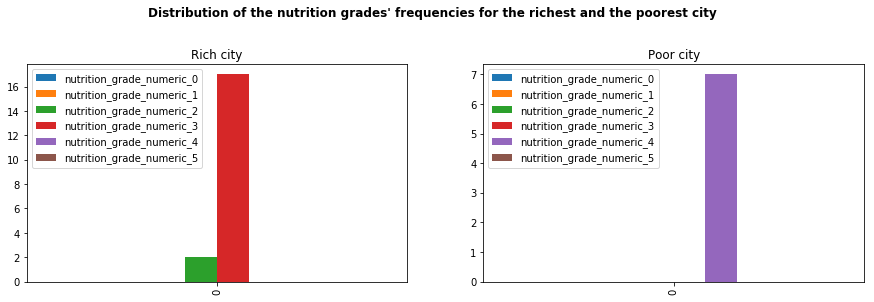

In [41]:
analyse_for_area(dataframe, 'City', 'city')

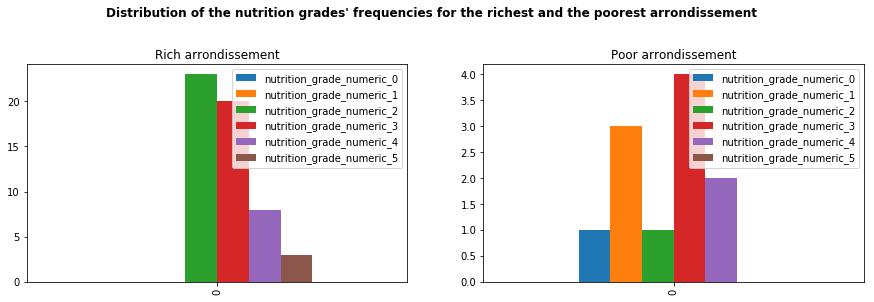

In [42]:
analyse_for_area(dataframe, 'Arrondissement', 'arrondissement')

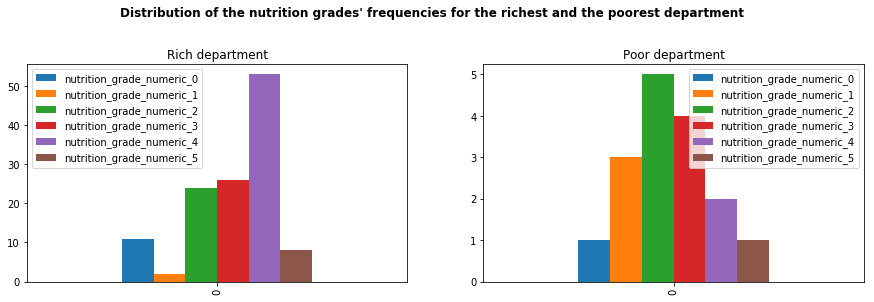

In [43]:
analyse_for_area(dataframe, 'Department', 'department')

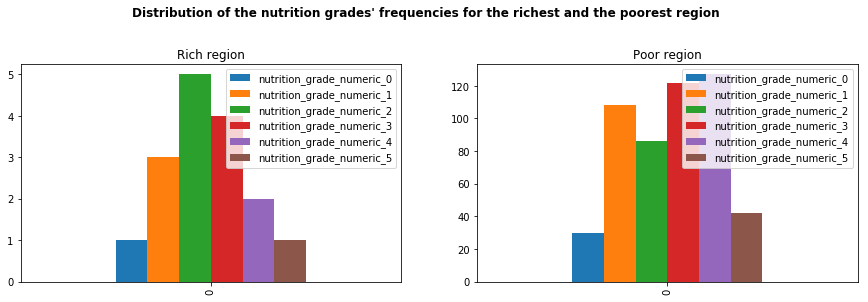

In [44]:
analyse_for_area(dataframe, 'Region', 'region')

We see that rich and poor areas can have very different distribution of the healthiness of the available products.
However, we cannot infer a correlation from only two areas.

Also, we see that the number of products varies a lot between areas. This was expected, as the products are entered by the users of OpenFoodFacts.

# 2. Distribution of the products per nutrition grade

* Nutrition grade has integer values between 1 and 5, 1 indicating healthy food items and 5 describing unhealthy items.

* Nutrition score (UK or Fr.) has values between -15 and 40. -15 indicates a healthy food item, 40 indicates an unhealthy food item. 

The correspondence between the two of them for solid foods is:

* Nutrition grade = 1 : nutrition score $\in [-15, : -1]$
* Nutrition grade = 2 : nutrition score $\in [0, 2]$
* Nutrition grade = 3 : nutrition score $\in [3, 10]$
* Nutrition grade = 4 : nutrition score $\in [11, 18]$
* Nutrition grade = 5 : nutrition score $\in [19, 40]$

The correspondence between the two of them for beverages is:

* Nutrition grade = 1 : Water
* Nutrition grade = 2 : nutrition score $\in [-15, 1]$
* Nutrition grade = 3 : nutrition score $\in [2, 5]$
* Nutrition grade = 4 : nutrition score $\in [6, 9]$
* Nutrition grade = 5 : nutrition score $\in [10, 40]$

https://fr.openfoodfacts.org/nutriscore

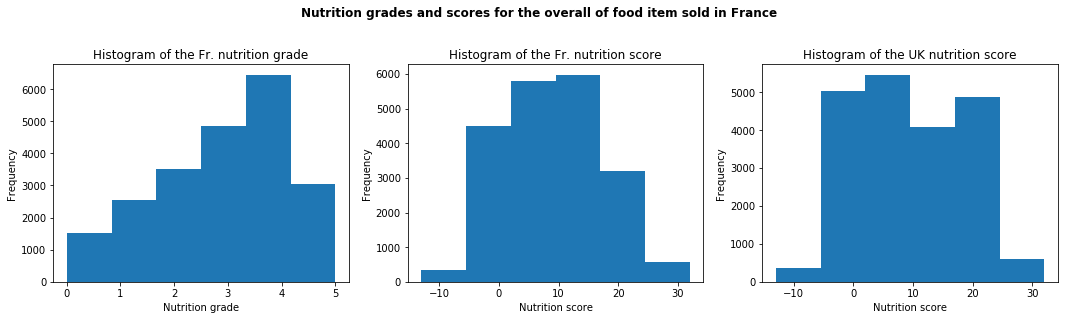

In [45]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
f.suptitle("Nutrition grades and scores for the overall of food item sold in France", 
           y=1.08, fontweight="bold")
dataframe['nutrition_grade_numeric'].plot.hist(bins=6, ax=ax1)
ax1.set_title("Histogram of the Fr. nutrition grade")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Nutrition grade")

dataframe['nutrition-score-fr_100g'].plot.hist(bins=6, ax=ax2)
ax2.set_title("Histogram of the Fr. nutrition score")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Nutrition score")

dataframe['nutrition-score-uk_100g'].plot.hist(bins=6, ax=ax3)
ax3.set_title("Histogram of the UK nutrition score")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Nutrition score")
plt.show()

*Reminder: `0` is equivalent to no data for Fr. nutrition grade.*

When we look at the nutrition grade histogram, we see that most of the products are labeled with a `3` or higher, which indicates that healthy products are rare in comparison. 

When looking at the nutrition score histograms, the lack of healthy products is reinforced, however there are also a lot less **very** unhealthy products.

Since these 3 columns in our dataframe describe the same thing, we need to choose one. Intuitively, we would choose Nutrition grade because it already gives us a judgement on the quality of the food independently on if the item is solid food or beverage. 

We will however introduce two more nutrition metrics, and after that we will select only the relevant columns in our dataframe (i.e. columns that don't have the **exact same information**, columns that are not **redundant**, or columns that have **enough non NaN values**). 

# 3. Implementation of custom nutrition scores

We introduce two more nutrition scores: calory density (the calories per serving) and calory deviation.

The *calory deviation* is computed according to the nutritional standards that among the calories we consume in a day, $21\%$ should come from proteins, $53\%$ from carbohydrates and $26\%$ from fat. We then compute a deviation from this standard for each product. 

* In the first case (calory density), the metric describes how largely a product is packed with calories. Since obesity is often linked with the density in calories of the ingested food items, this metric might be useful.

* In the second case (calory deviation), we aim at observing whether the products follow a healthy calory distribution. This metric would show us if a certain region has bad nutrition habits with respect to the ratios of nutriments they should eat.

In [46]:
# we consider only the energy per 100g and the serving size
cals = dataframe[['energy_100g', 'serving_size']]
# we drop nan values, and serving sizes that are not relevant
cals = cals.dropna()
cals = cals.drop(cals[cals['serving_size'].str.contains("mg")].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('oeuf')].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('Deux tranches g')].index)
# we keep only the number of units of the usual measure unit for the product
cal = cals['serving_size'].str.replace('.*?(?P<number>[0-9.,]+)\s*(G|g|f|ml|mL).*', '\\g<number>')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(cl|cL).*', '\\g<number>0')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(Kg|L|l).*', '\\g<number>000')
# we remove values that are composed only of letters
cal = cal.str.replace('[^0-9]+', '')
cal = cal.replace('', np.nan)
cal = cal.dropna()
# we cast everything to float
cal = cal.str.replace(",", ".").astype('float')
cals.serving_size = cal
# and reinsert it in our dataframe
dataframe.loc[:, 'serving_size'] = cal

cal_density = cals.serving_size * cals.energy_100g / 100

**Note**

Proteins bring 4 calories per gramm, and should constitue 21% of our calories.

Carbohydrates also bring 4 calories per gramm, and should constitue 53% of our calories.

Fat brings 9 calories per gramm, and should constitue the remaining 26% of our calories.

Hence the computations below:

In [47]:
# energy has to be divided by 4.184 to convert from Joules to kilocalories
energy_in_kcal_100g = dataframe.energy_100g / 4.184
cal_deviation = ((dataframe.fat_100g * 9 / energy_in_kcal_100g - 0.26)**2 + 
                (dataframe.carbohydrates_100g * 4 / energy_in_kcal_100g - 0.53)**2 +
                (dataframe.proteins_100g * 4 / energy_in_kcal_100g - 0.21)**2)/3
# we remove unknown and infinite values
cal_deviation.replace(np.infty, np.nan, inplace=True)
cal_deviation.dropna(inplace=True)
cal_deviation.describe()

count    21376.000000
mean         5.766193
std        563.562554
min          0.000044
25%          0.017735
50%          0.078327
75%          0.160257
max      58205.149533
dtype: float64

In [48]:
# we insert our columns in our dataframe
dataframe.loc[:, 'cal_density'] = cal_density
dataframe.loc[:, 'cal_deviation'] = cal_deviation
dataframe.head()

Number of fiscal households  Number of taxed households  \
0                          206                         108   
1                          206                         108   
2                          206                         108   
3                          206                         108   
4                          206                         108   

   Mean reference fiscal income (in k€)  food_item_index  \
0                             27.468762           431441   
1                             27.468762           348749   
2                             27.468762           348720   
3                             27.468762           348741   
4                             27.468762           348708   

   nutrition-score-fr_100g  nutrition-score-uk_100g  nutrition_grade_numeric  \
0                     16.0                     16.0                        4   
1                     15.0                     15.0                        4   
2                     16.0                     16.0                        4   
3                     11.0                     11.0                        4   
4                     15.0                     15.0                        4   

   serving_size  energy_100g  fat_100g      ...        \
0           NaN        883.0     12.00      ...         
1           NaN        703.0      9.30      ...         
2           NaN        900.0     12.00      ...         
3          50.0        514.0      3.66      ...         
4         100.0        699.0      9.40      ...         

   Share of retreat pension revenue (%)  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   Share of heritage revenue and other (%)  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   Share of social benefits revenue (%)  Share of taxes (%)      City  \
0                                   NaN                 NaN  Apremont   
1                                   NaN                 NaN  Apremont   
2                                   NaN                 NaN  Apremont   
3                                   NaN                 NaN  Apremont   
4                                   NaN                 NaN  Apremont   

   Department  Region  Arrondissement  cal_density  cal_deviation  
0          10      84            1004          NaN       0.133987  
1          10      84            1004          NaN       0.116812  
2          10      84            1004          NaN       0.130923  
3          10      84            1004        257.0       0.157268  
4          10      84            1004        699.0       0.117324  

[5 rows x 36 columns]

# 4. Decide which columns to keep

In [49]:
numeric_cols = ['Number of fiscal households', 'Number of taxed households', 
                'Mean reference fiscal income (in k€)', 'food_item_index', 'nutrition-score-fr_100g', 
                'nutrition-score-uk_100g','nutrition_grade_numeric', 'serving_size', 'energy_100g', 
                'fat_100g','saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g','sugars_100g', 
                'fiber_100g', 'Median revenue euros','Total poverty rate (%)', 'Poverty rate (-30) (%)',
               'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
               'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
               'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
               'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
               'Share of retreat pension revenue (%)',
               'Share of heritage revenue and other (%)',
               'Share of social benefits revenue (%)', 'Share of taxes (%)',
               'cal_density', 'cal_deviation']

In [50]:
for column in numeric_cols:
    nonna = len(dataframe[dataframe[column].apply(lambda x: not np.isnan(x))]) / len(dataframe)
    print('{:<45s}{:<30s}{:<25.1%}'.format(column, 'Number of non-na:', nonna))

Number of fiscal households                  Number of non-na:             100.0%                   
Number of taxed households                   Number of non-na:             100.0%                   
Mean reference fiscal income (in k€)         Number of non-na:             100.0%                   
food_item_index                              Number of non-na:             100.0%                   
nutrition-score-fr_100g                      Number of non-na:             93.1%                    
nutrition-score-uk_100g                      Number of non-na:             93.1%                    
nutrition_grade_numeric                      Number of non-na:             100.0%                   
serving_size                                 Number of non-na:             55.4%                    
energy_100g                                  Number of non-na:             99.1%                    
fat_100g                                     Number of non-na:             99.4%           

#### Mutual information on economical factors

In [71]:
eco_df = pd.read_csv('../data/processed/clean_food_cities_arrond_with_tax.csv', low_memory=False)

eco_df = eco_df.drop(columns=['Unnamed: 0', 'food_item_index', 'nutrition-score-fr_100g', 
                              'nutrition_grade_numeric', 'energy_100g', 'fat_100g', 
                              'saturated-fat_100g', 'proteins_100g', 'fiber_100g', 
                              'carbohydrates_100g', 'sugars_100g', 'nutrition-score-uk_100g', 
                              'serving_size', 'City','Department', 'Region', 'Arrondissement', 
                              'Poverty rate (-30) (%)','Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
                              'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)', 'Poverty rate (75+) (%)', 
                              'Poverty rate (house owners) (%)', 'Poverty rate (tenants) (%)', 'Share of taxes (%)', 
                              'Number of fiscal households', 'Number of taxed households']).dropna()
eco_df.head()

Mean reference fiscal income (in k€)  Median revenue euros  \
18                             25.404703               19347.0   
19                             22.219435               18563.0   
20                             22.219435               18563.0   
21                             22.219435               18563.0   
22                             22.219435               18563.0   

    Total poverty rate (%)  Share of activity revenue (%)  \
18               18.463738                           75.2   
19               18.618075                           65.9   
20               18.618075                           65.9   
21               18.618075                           65.9   
22               18.618075                           65.9   

    Share of retreat pension revenue (%)  \
18                                  25.4   
19                                  31.2   
20                                  31.2   
21                                  31.2   
22                                  31.2   

    Share of heritage revenue and other (%)  \
18                                      7.0   
19                                     11.1   
20                                     11.1   
21                                     11.1   
22                                     11.1   

    Share of social benefits revenue (%)  
18                                   5.7  
19                                   7.1  
20                                   7.1  
21                                   7.1  
22                                   7.1

In [72]:
mutual_info = pd.DataFrame(0, index=eco_df.columns, columns=eco_df.columns)

for (i, feat) in enumerate(eco_df.columns):
    mutual_info.loc[feat, eco_df.columns[i:]] = mutual_info_regression(eco_df[eco_df.columns[i:]], eco_df[feat])
    mutual_info.loc[feat, eco_df.columns[i:]] = mutual_info.loc[feat, eco_df.columns[i:]]/mutual_info.loc[feat,feat]
    mutual_info.loc[eco_df.columns[i:], feat] = mutual_info.loc[feat, eco_df.columns[i:]]

mutual_info

Mean reference fiscal income (in k€)  \
Mean reference fiscal income (in k€)                                 1.000000   
Median revenue euros                                                 0.936148   
Total poverty rate (%)                                               0.922294   
Share of activity revenue (%)                                        0.834870   
Share of retreat pension revenue (%)                                 0.801710   
Share of heritage revenue and other (%)                              0.693723   
Share of social benefits revenue (%)                                 0.687858   

                                         Median revenue euros  \
Mean reference fiscal income (in k€)                 0.936148   
Median revenue euros                                 1.000000   
Total poverty rate (%)                               0.937718   
Share of activity revenue (%)                        0.848260   
Share of retreat pension revenue (%)                 0.815996   
Share of heritage revenue and other (%)              0.705750   
Share of social benefits revenue (%)                 0.700394   

                                         Total poverty rate (%)  \
Mean reference fiscal income (in k€)                   0.922294   
Median revenue euros                                   0.937718   
Total poverty rate (%)                                 1.000000   
Share of activity revenue (%)                          0.845943   
Share of retreat pension revenue (%)                   0.811460   
Share of heritage revenue and other (%)                0.703792   
Share of social benefits revenue (%)                   0.698738   

                                         Share of activity revenue (%)  \
Mean reference fiscal income (in k€)                          0.834870   
Median revenue euros                                          0.848260   
Total poverty rate (%)                                        0.845943   
Share of activity revenue (%)                                 1.000000   
Share of retreat pension revenue (%)                          0.813823   
Share of heritage revenue and other (%)                       0.687115   
Share of social benefits revenue (%)                          0.670190   

                                         Share of retreat pension revenue (%)  \
Mean reference fiscal income (in k€)                                 0.801710   
Median revenue euros                                                 0.815996   
Total poverty rate (%)                                               0.811460   
Share of activity revenue (%)                                        0.813823   
Share of retreat pension revenue (%)                                 1.000000   
Share of heritage revenue and other (%)                              0.675293   
Share of social benefits revenue (%)                                 0.662461   

                                         Share of heritage revenue and other (%)  \
Mean reference fiscal income (in k€)                                    0.693723   
Median revenue euros                                                    0.705750   
Total poverty rate (%)                                                  0.703792   
Share of activity revenue (%)                                           0.687115   
Share of retreat pension revenue (%)                                    0.675293   
Share of heritage revenue and other (%)                                 1.000000   
Share of social benefits revenue (%)                                    0.623501   

                                         Share of social benefits revenue (%)  
Mean reference fiscal income (in k€)                                 0.687858  
Median revenue euros                                                 0.700394  
Total poverty rate (%)                                               0.698738  
Share of activity revenue (%)                                        0.670190  
Share of retreat pe

In [73]:
plot_cols = ['Mean fiscal \n  income (k€)', 'Median revenue (€)',
       'Total poverty rate (%)', 'Share of \n activity revenue (%)',
       'Share of retreat \n pension revenue (%)',
       'Share of heritage \n revenue and other (%)',
       'Share of social \n benefits revenue (%)']

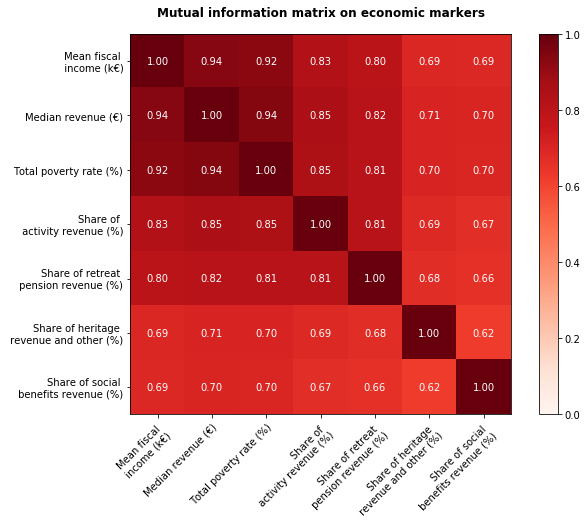

In [74]:
matrix  = np.array(mutual_info)

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(matrix, vmin=0, vmax=1, cmap='Reds')

# We want to show all ticks...
ax.set_xticks(np.arange(len(plot_cols)))
ax.set_yticks(np.arange(len(plot_cols)))
# ... and label them with the respective list entries
ax.set_xticklabels(plot_cols)
ax.set_yticklabels(plot_cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(plot_cols)):
    for j in range(len(plot_cols)):
        string = "{0:.2f}".format(matrix[i, j])
        text = ax.text(j, i, string,
                       ha="center", va="center", color="w")

ax.set_title('Mutual information matrix on economic markers', fontweight='bold', y=1.03)
fig.colorbar(im)
plt.savefig('../data/processed/eco_mutualinfo.png')
plt.show()

We decided to keep all nutritional columns and all economical columns that have at least $90 \%$ of non NaN values. Indeed, all nutritional columns are probably useful for our analysis, however if we keep economical columns that have a lot of NaN values within them, we will lose information when we use `dropna()`. Moreover, we see n the above correlation matrix that the information about the revenue conveys all the economical information we need (since it is closely linked with all the other economic features such as poverty rate, etc).

This leaves us with:

* 1 column describing the food item's identifier:
    - food item index

* 11 columns describing nutritional features:
    - nutrition-score-fr_100g            
    - nutrition-score-uk_100g            
    - nutrition_grade_numeric           
    - serving_size           
    - energy_100g                        
    - fat_100g                           
    - saturated-fat_100g                 
    - proteins_100g                      
    - carbohydrates_100g                 
    - sugars_100g                        
    - fiber_100g

* 1 column describing economic features: 
    - Median revenue euros
    
* 4 columns describing geographical features
    - City
    - Arrondissement
    - Department
    - Region

In [75]:
dataframe = dataframe[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation', 
                       'Median revenue euros', 'City', 'Department', 
                       'Region', 'Arrondissement']]

KeyError: "['nutrition-score-uk_100g'] not in index"

**2. Mutual Information**

Now that we have the important elements from the two datasets we can apply feature reduction using mutual information (MI). This measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. We thought also about using PCA but as we are looking into selecting features from our original data, MI gives an easier interpretation of the dependencies.

In [52]:
new_df = dataframe.drop(columns=['food_item_index','Department','Arrondissement','City','Region']).dropna()

mutual_info = pd.DataFrame(0, index=new_df.columns, columns=new_df.columns)

for (i, feat) in enumerate(new_df.columns):
    mutual_info.loc[feat, new_df.columns[i:]] = mutual_info_regression(new_df[new_df.columns[i:]], new_df[feat])
    mutual_info.loc[feat, new_df.columns[i:]] = mutual_info.loc[feat, new_df.columns[i:]]/mutual_info.loc[feat,feat]
    mutual_info.loc[new_df.columns[i:], feat] = mutual_info.loc[feat, new_df.columns[i:]]

mutual_info

nutrition-score-fr_100g  \
nutrition-score-fr_100g                              1.000000   
nutrition-score-uk_100g                              0.898409   
nutrition_grade_numeric                              0.432065   
serving_size                                         0.120980   
energy_100g                                          0.305954   
fat_100g                                             0.218805   
saturated-fat_100g                                   0.215865   
proteins_100g                                        0.136514   
carbohydrates_100g                                   0.187847   
sugars_100g                                          0.157840   
fiber_100g                                           0.107834   
cal_density                                          0.206743   
cal_deviation                                        0.227189   
Median revenue euros                                 0.200500   
Mean reference fiscal income (in k€)                 0.175767   
Number of fiscal households                          0.166529   
Number of taxed households                           0.160367   

                                      nutrition-score-uk_100g  \
nutrition-score-fr_100g                              0.898409   
nutrition-score-uk_100g                              1.000000   
nutrition_grade_numeric                              0.406890   
serving_size                                         0.132159   
energy_100g                                          0.318743   
fat_100g                                             0.243131   
saturated-fat_100g                                   0.247121   
proteins_100g                                        0.154869   
carbohydrates_100g                                   0.195515   
sugars_100g                                          0.166496   
fiber_100g                                           0.104412   
cal_density                                          0.207742   
cal_deviation                                        0.235766   
Median revenue euros                                 0.214620   
Mean reference fiscal income (in k€)                 0.191740   
Number of fiscal households                          0.179828   
Number of taxed households                           0.178950   

                                      nutrition_grade_numeric  serving_size  \
nutrition-score-fr_100g                              0.432065      0.120980   
nutrition-score-uk_100g                              0.406890      0.132159   
nutrition_grade_numeric                              1.000000      0.170733   
serving_size                                         0.170733      1.000000   
energy_100g                                          0.351209      0.236936   
fat_100g                                             0.269200      0.170082   
saturated-fat_100g                                   0.299285      0.142292   
proteins_100g                                        0.119004      0.173719   
carbohydrates_100g                                   0.172498      0.201287   
sugars_100g                                          0.162277      0.157971   
fiber_100g                                           0.063910      0.111593   
cal_density                                          0.222124      0.334860   
cal_deviation                                        0.255085      0.210329   
Median revenue euros                                 0.317912      0.375657   
Mean reference fiscal income (in k€)                 0.298603      0.339144   
Number of fiscal households                          0.291717      0.326994   
Number of taxed households                           0.288004      0.319122   

                                      energy_100g  fat_100g  \
nutrition-score-fr_100g                  0.305954  0.218805   
nutrition-score-uk_100g                  0.318743  0.243131   
nutrition_grade_numeric                  0.351209  0.269200   
serving_size         

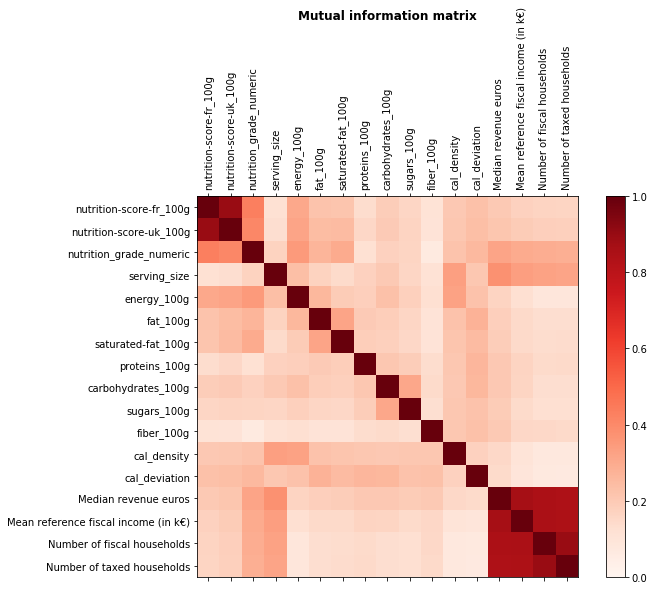

In [53]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
names = list(mutual_info.columns)
cax = ax.matshow(mutual_info, vmin=0, vmax=1, cmap='Reds')
ticks = np.arange(0, len(new_df.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Mutual information matrix', y=1.45, fontweight='bold')
f.colorbar(cax)
plt.show()

Based on the figure above, we deduce that the MI between nutrition-score-fr_100g and nutrition-score-uk_100g is very high, leading to the drop of **nutrition-score-uk_100g**.

In [54]:
dataframe.drop(columns=['nutrition-score-uk_100g'], inplace=True)

# 5. Aggregation

First, we have to remove the DOM-TOMS since the cultural differences are too large (Guadeloupe, Guyane, etc).
Then, we transform the dataframe to be able to do the analysis at four different increasing levels, City, Arrondissement, Departement and Region level. For this reason, we create four different aggregations of the dataframe using each time the corresponding column.

In [55]:
dom_tom = [1, 2, 4]
dataframe['Region'] = dataframe['Region'][dataframe['Region'].apply(lambda x: x not in dom_tom)]

In [56]:
nutritional_columns = ['nutrition-score-fr_100g', 'nutrition_grade_numeric',
                       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'proteins_100g', 
                       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'cal_deviation']
economic_columns = ['Median revenue euros']
geo_columns = ['City','Department', 'Region', 'Arrondissement']

In [77]:
def aggregate(df, area_column):
    """Aggregate our nutritional data per geographic area
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the relevant information.
    area_column: string
        Name of the column coding the geographic area.
    
    Returns:
    ---------
    median_df: pandas.Dataframe
        Dataframe conatining the median value for each nutritional feature, grouped by geographic area.
    """
    drop_cols = geo_columns
    #drop_cols.remove(area_column)
    
    median_df = df.drop(columns=drop_cols).dropna().groupby(area_column).median()
    
    return median_df

In [78]:
aggregated_city_med = aggregate(dataframe, 'City') 
aggregated_arrondissement_med = aggregate(dataframe, 'Arrondissement') 
aggregated_department_med = aggregate(dataframe, 'Department') 
aggregated_region_med = aggregate(dataframe, 'Region') 

# 6. Clustering

We created two dataframes per geographic level, one that aggregates by mean and one that aggregates by median. There are no significant differences between the two of them when we visualize the data. We kept both values for the computation of the correlation, however to check if there are clusters we only kept the dataframe aggregated by the mean.

**1. Cities**

In [79]:
def plot_scatter(df):
    """Display the scatter plots representing the relationship between each nutrition attribute 
    and the Median Revenue
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the relevant information.
    """
    fig, axs = plt.subplots(3, 4, figsize=(25, 18))
    fig.suptitle("Scatter plots of the relationships between each nutrition attribute and the Median Revenue", 
                fontweight="bold")
    i = 0;
    j = 0;
    count = 1;
    for col in nutritional_columns:
        df.plot.scatter(x='Median revenue euros', y=col, ax=axs[i, j])
        axs[i, j].set_title(col)
        if count % 4 == 0:
            i = i + 1;
        j = (j + 1) % 4;
        count = count + 1
    fig.show()

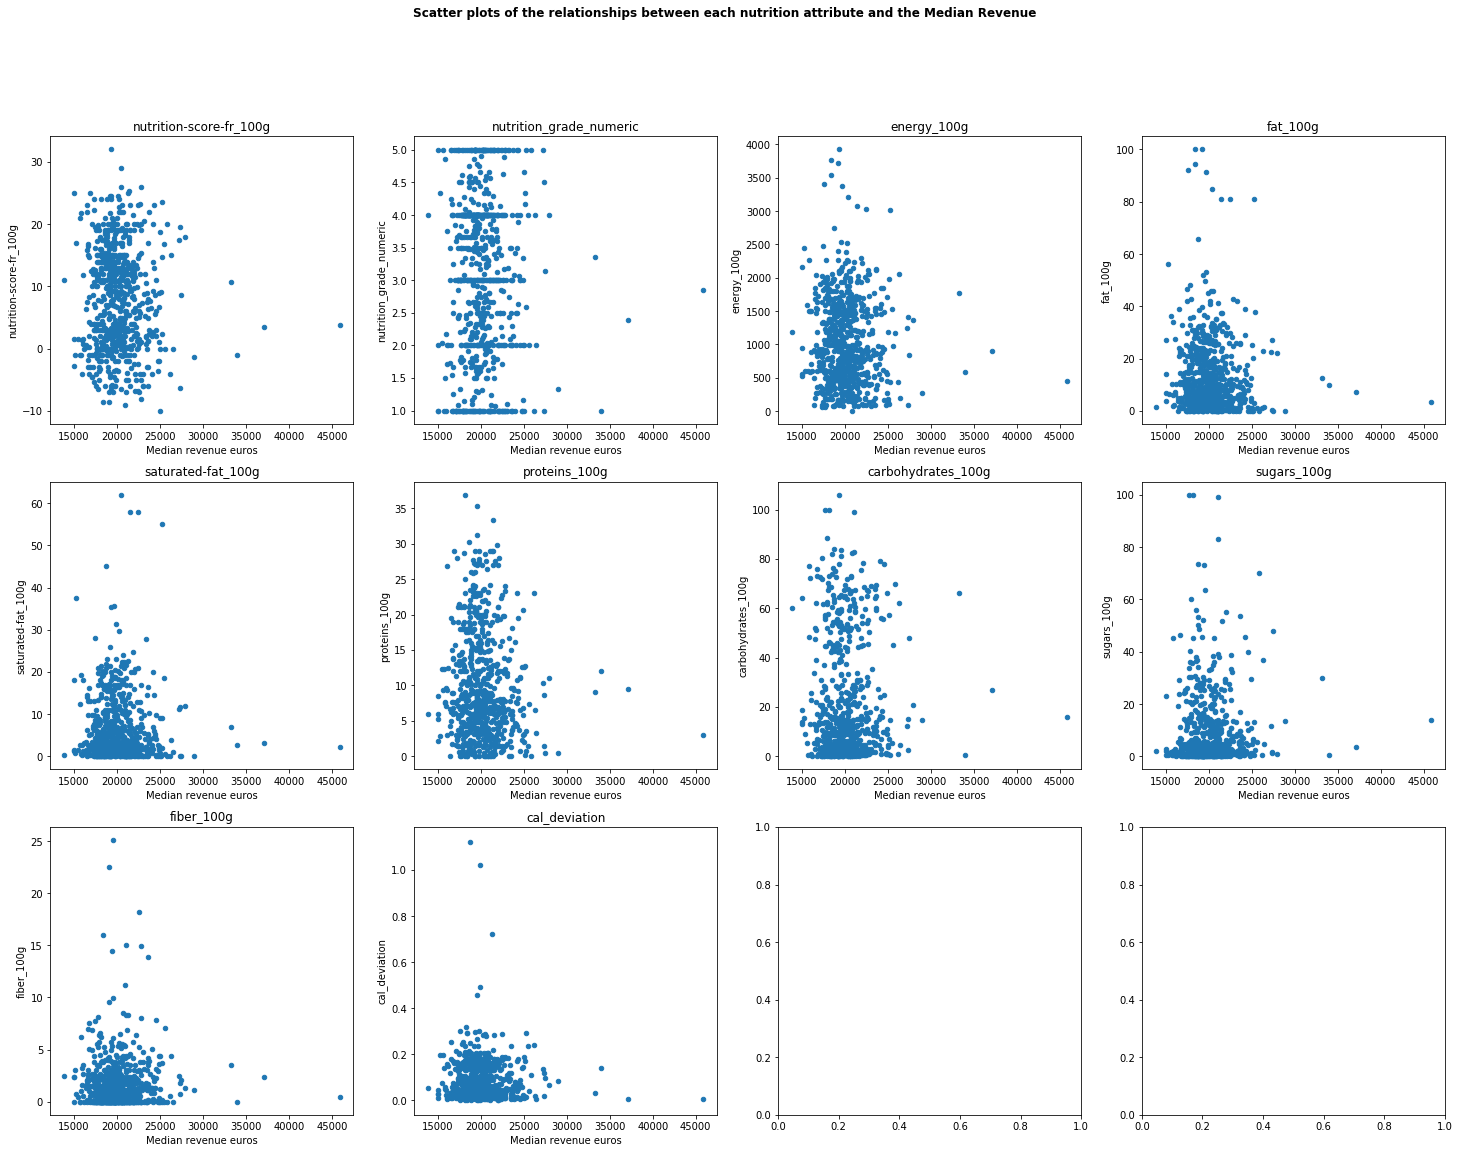

In [80]:
plot_scatter(aggregated_city_mean)

Here we cannot see clear clusters, especially not across different median revenues. The datapoints are all concentrated around 20000 €, and we can see some vague clusters for the graph plotting the **carbohydrates** against **median revenue** (plot (2,4)). The clusters are however not differentiated according to median revenue.

**2. Arrondissements**

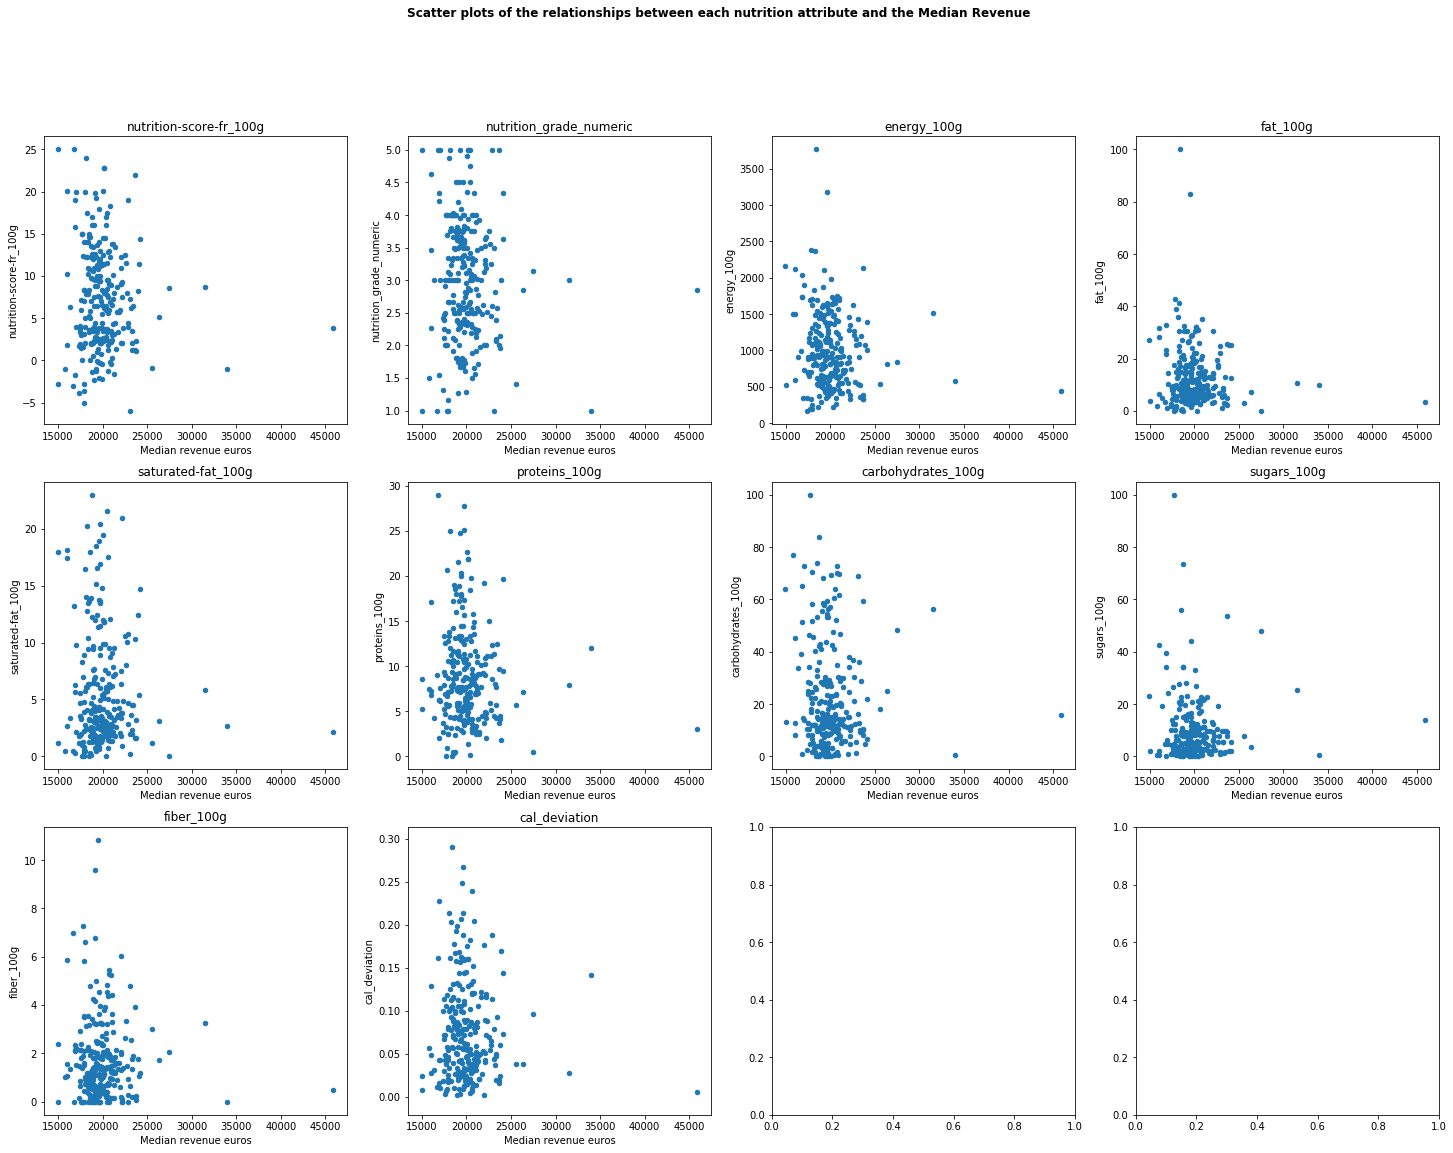

In [61]:
plot_scatter(aggregated_arrondissement_mean)

Same as above, no clear clusters emerge from these scatter plots.

**3. Departments**

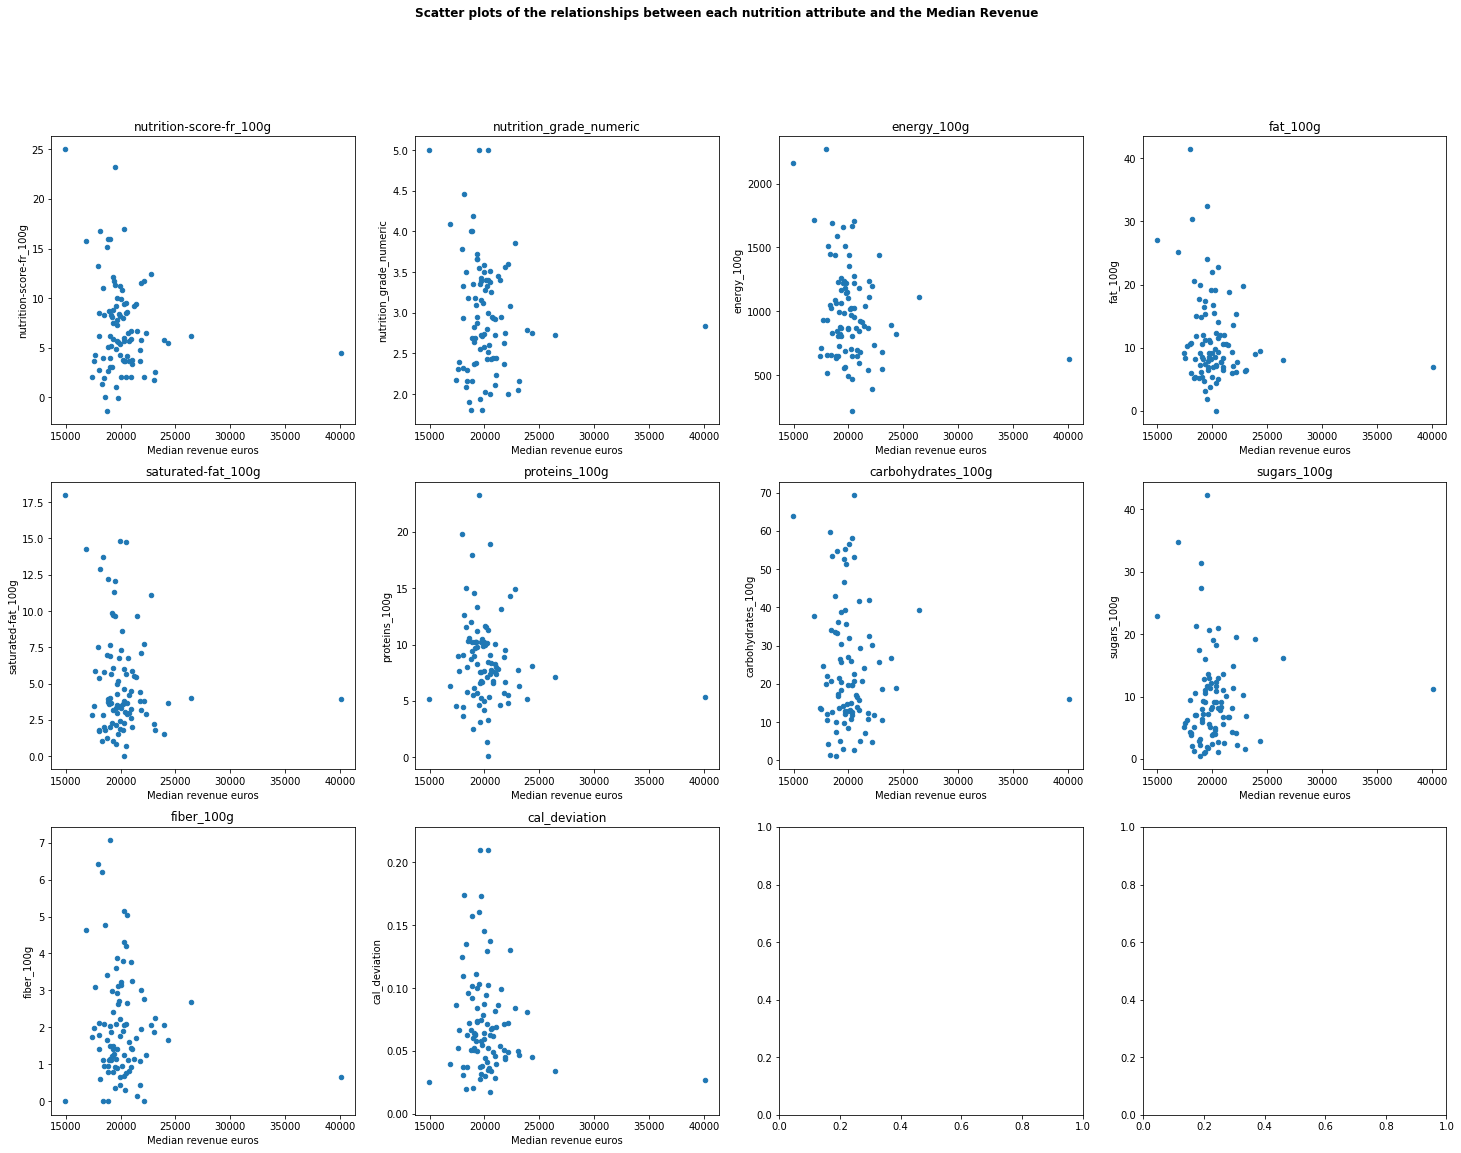

In [62]:
plot_scatter(aggregated_department_mean)

Once again, all blobs are concentrated around 20000€ and we cannot extract actual clusters.

**4. Regions**

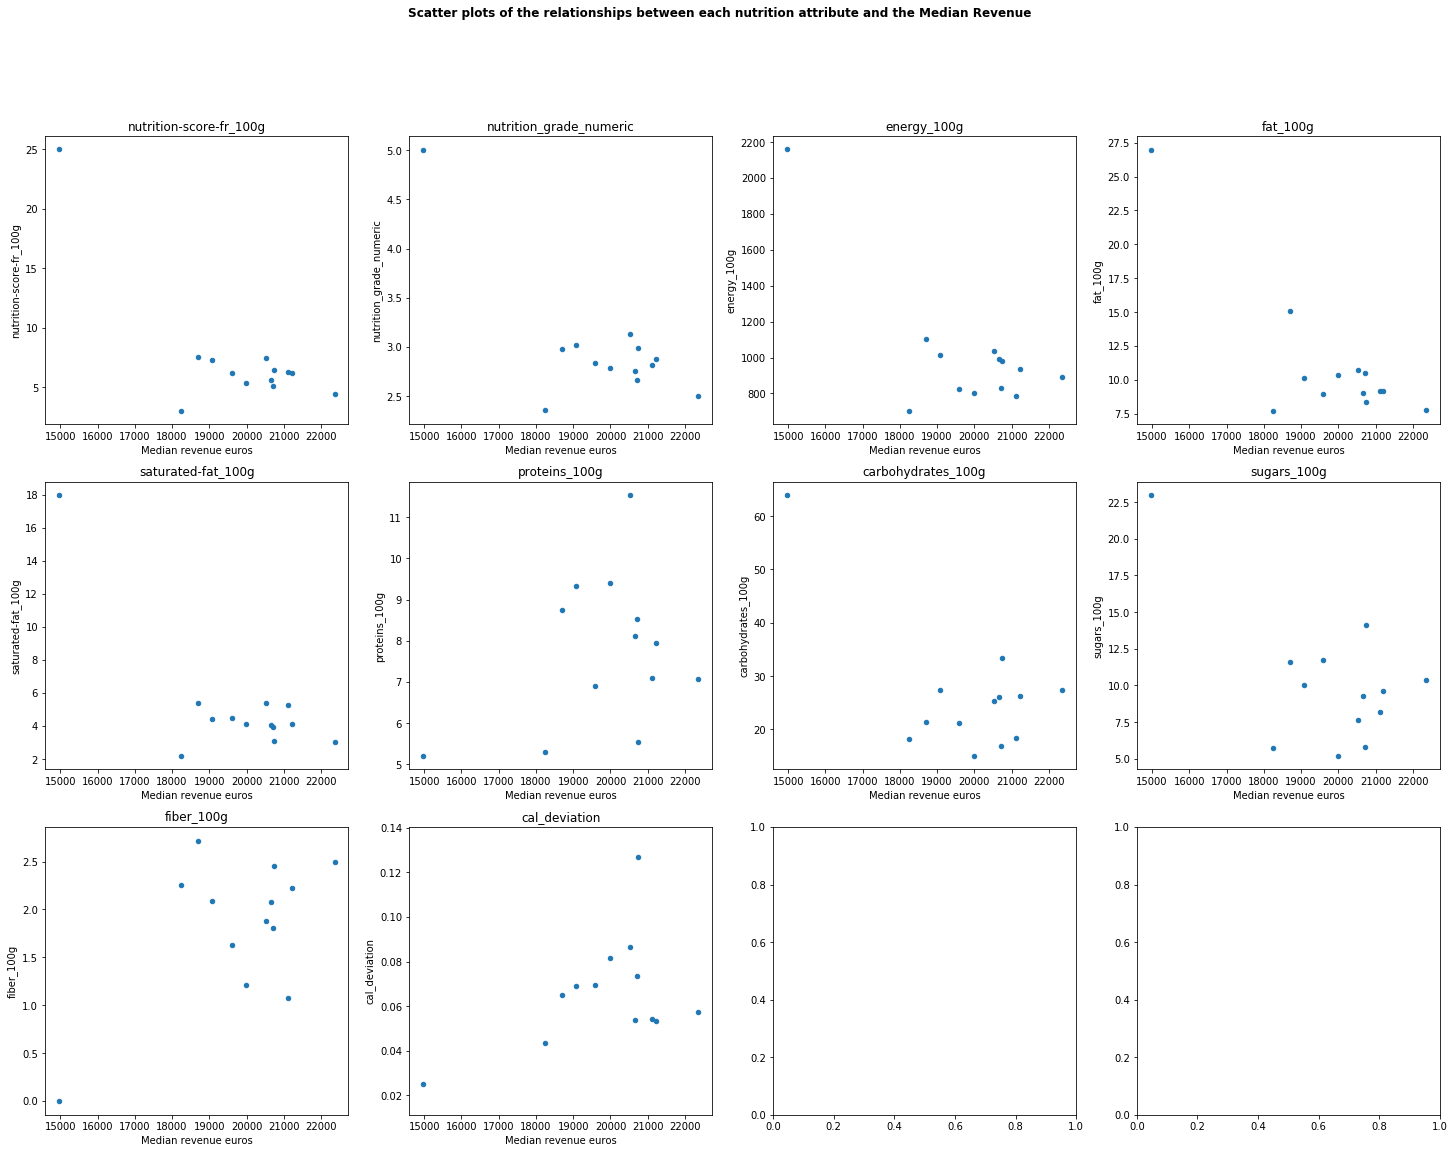

In [63]:
plot_scatter(aggregated_region_mean)

Here, we cannot find clusters but we get a hint of some correlations. These links are explored below. 

In order to make sure that no good clusters can be found, we used DBSCAN with several parameters. We plotted only the results for **nutritional score** against **median revenue** since it was the most significant plot.

In [64]:
def cluster(df, eps=0.3, min_samples=10):
    """Compute and display clusters
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the needed information.
    eps: float
        Distance to consider for neighbors for the DBSCAN algorithm.
    min_samples: int
        Minimum number of points to consider the set of points as a cluster and no outliers.
    
    Returns:
    ---------
    labels: numpy.ndarray
        The labels associated with each point.
    """
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    if n_clusters_ > 0:
        print("Silhouette Coefficient: %0.3f"
              % metrics.silhouette_score(X, labels))
    else:
        print("Silhouette Coefficient could not be computed for 0 clusters")

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

Estimated number of clusters: 29
Estimated number of noise points: 0
Silhouette Coefficient: -0.162


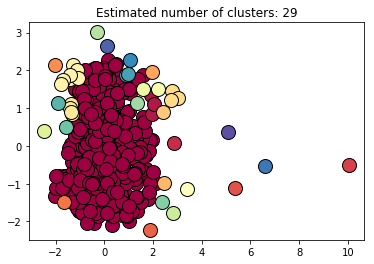

In [65]:
labels = cluster(aggregated_city_mean[['Median revenue euros', 'nutrition-score-fr_100g']], 0.3, 1)

Estimated number of clusters: 26
Estimated number of noise points: 0
Silhouette Coefficient: -0.224


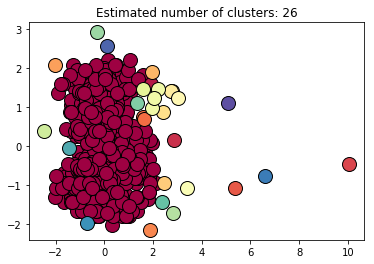

In [66]:
labels = cluster(aggregated_city_med[['Median revenue euros', 'nutrition-score-fr_100g']], 0.3, 1)

Estimated number of clusters: 1
Estimated number of noise points: 1
Silhouette Coefficient: 0.832


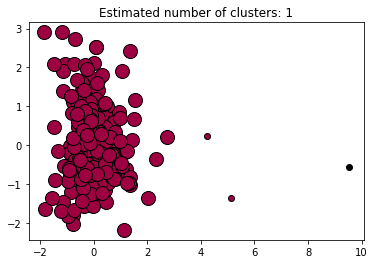

In [67]:
labels = cluster(aggregated_arrondissement_mean[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 10)

Estimated number of clusters: 1
Estimated number of noise points: 1
Silhouette Coefficient: 0.807


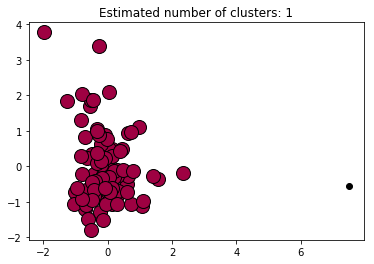

In [68]:
labels = cluster(aggregated_department_mean[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 2)

Estimated number of clusters: 1
Estimated number of noise points: 1
Silhouette Coefficient: 0.813


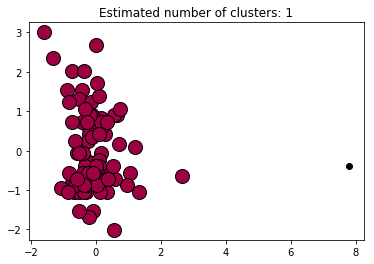

In [69]:
labels = cluster(aggregated_department_med[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 2)

In [70]:
labels = cluster(aggregated_region_mean[['Median revenue euros', 'energy_100g']], 100, 1)

Estimated number of clusters: 1
Estimated number of noise points: 0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

As predicted above, we could not find any meaningful clusters and the maximum Silhouette coefficient that we obtain is around 0.3 (perfect clustering is 1). 

We will hence use linear correlation to explore the links.

In [81]:
nutri_df = dataframe[nutritional_columns].dropna()
nutri_df.head()

nutrition-score-fr_100g  nutrition_grade_numeric  energy_100g  fat_100g  \
0                      16.0                        4        883.0      12.0   
1                      15.0                        4        703.0       9.3   
12                     16.0                        4        900.0      12.0   
13                     14.0                        4        743.0       6.2   
16                     15.0                        4        699.0       9.4   

    saturated-fat_100g  proteins_100g  carbohydrates_100g  sugars_100g  \
0                  4.4           25.0                 0.6          0.5   
1                  3.8           19.0                 1.9          1.2   
12                 4.4           25.0                 0.6          0.5   
13                 2.4           29.8                 0.4          0.3   
16                 3.9           18.7                 1.9          1.7   

    fiber_100g  cal_deviation  
0          0.5       0.133987  
1          0.3       0.116812  
12         0.0       0.130923  
13         0.5       0.162372  
16         0.0       0.117324

In [82]:
nutri = np.array(nutri_df)

degree_weighted = nutri.sum(1)
D = np.diag(degree_weighted)
D_norm = np.diag(np.sqrt(1./degree_weighted))
D_norm[D_norm == np.inf] = 0

laplacian_combinatorial = sparse.csr_matrix(D - nutri)
laplacian_normalized = sparse.csr_matrix(D_norm@laplacian_combinatorial@D_norm)

ValueError: operands could not be broadcast together with shapes (10153,10153) (10153,10) 

# 7. Correlation analysis 

In [86]:
corr_cols = ['nutrition-score-fr_100g', 'nutrition_grade_numeric',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'proteins_100g',
       'fiber_100g', 'carbohydrates_100g', 'sugars_100g', 'cal_density', 'cal_deviation',
       'Median revenue euros']
corr_names = ['Nutrition score', 'Nutrition grade \n(numeric)',
       'Energy \n (per 100 g)', 'Fat \n (per 100 g)', 'Saturated fat \n (per 100g)', 'Proteins \n (per 100g)',
       'Fiber (per 100g)', 'Carbohydrates \n (per 100 g)', 'Sugars \n(per 100g)', 'Calory density', 'Calory deviation',
       'Median revenue (€)']

In [87]:
def plot_corr_matrix(df, geography):
    """Display the correlation matrix for medians for a geographic area
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the values of the medians for each feature, grouped by geographic area.
    geography: string
        Name of the type of geographic area considered.
    """
    corr = np.array(df[corr_cols].corr())
    names = corr_names

    fig, ax = plt.subplots(figsize=(12, 9))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap='bwr', alpha=0.5)


    # We want to show all ticks...
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    df_corr = df[corr_cols]
    columns = df_corr.columns

    for i in range(len(names)):
        for j in range(len(names)):
            string = "{0:.2f}".format(corr[i, j])
            if (j == 11 and i != 11):
                r, p = stats.pearsonr(df_corr[columns[i]], df_corr['Median revenue euros'])
                
                if p < 0.05:
                    text = ax.text(j, i, string,
                                   ha="center", va="center", color='black', fontweight='bold')
                else: 
                    text = ax.text(j, i, string, ha="center", va="center", color="w")
                        
            else:
                text = ax.text(j, i, string, ha="center", va="center", color="w")

    fig.colorbar(im)
    ax.set_title("Correlation matrix for median aggregated values by " + geography, y=1.03, fontweight="bold")
    plt.show()

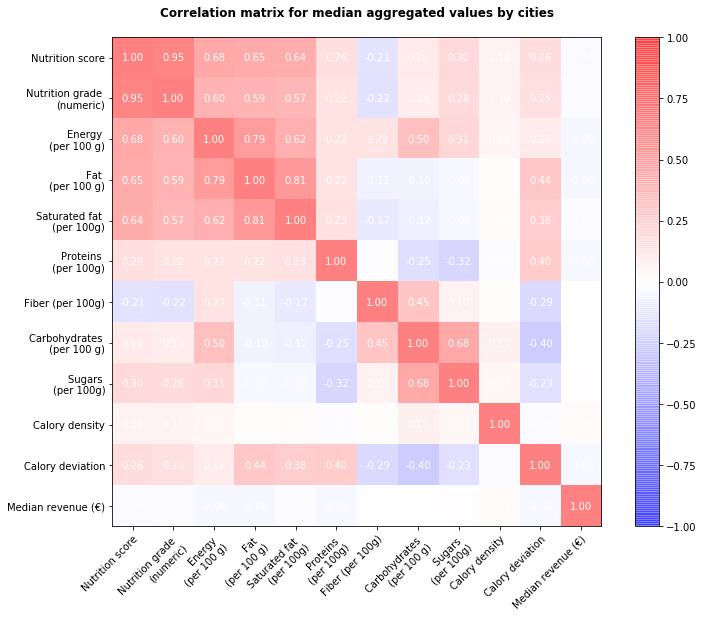

In [88]:
plot_corr_matrix(aggregated_city_med, "cities")

At a city level, we cannot see much from the correlation matrix. The only correlations that we find are among nutritional features, e.g. the nutrition score and grade (high when unhealthy, low when healthy) is positively correlated with energy, sugars, fat and negatively correlated with fiber. 

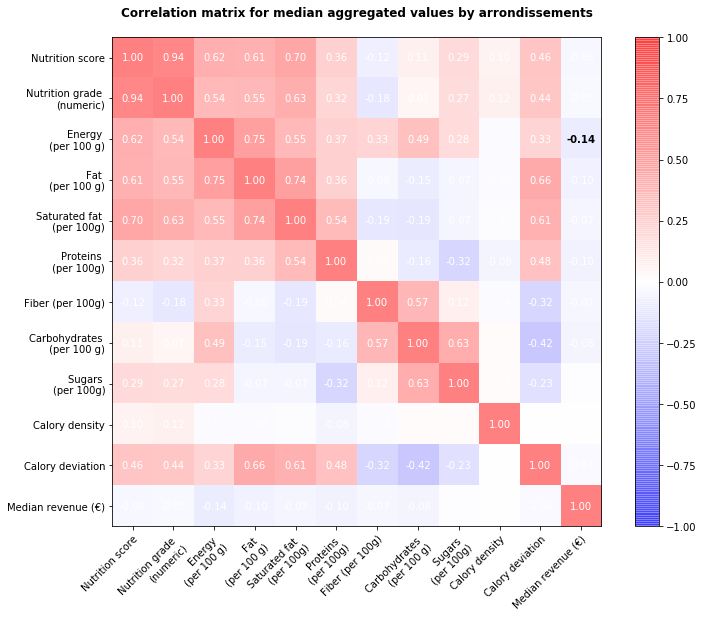

In [89]:
plot_corr_matrix(aggregated_arrondissement_med, "arrondissements")

At the arrondissement level, we can also mostly see the correlations between nutritional features. We can however see that the correlation between nutritional score and median revenue is negative, according to the colorbar, but probably not enough to see an actual relation. 

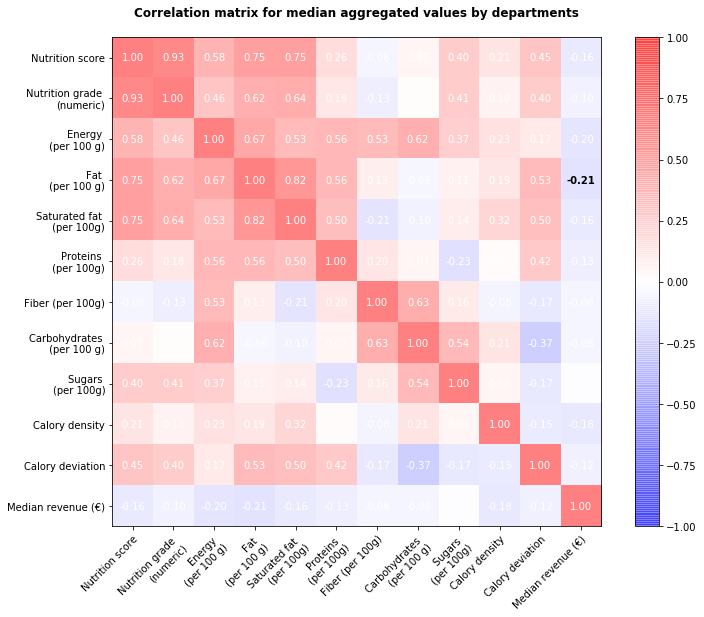

In [90]:
plot_corr_matrix(aggregated_department_med, "departments")

At the Department level (second largest subdivision of the French territory), the correlations between the nutritional features are more accentuated, especially between nutrition score and energy, fat and saturated fat. We can see that the median revenue column (the last column) has negative correlation values for most of the other features.

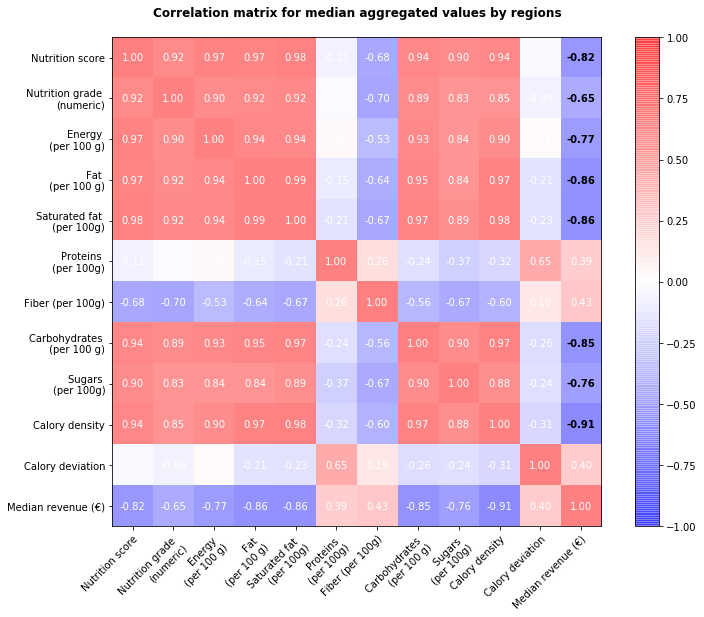

In [91]:
plot_corr_matrix(aggregated_region_med, "regions")

Hooray, we found something at the region level!

Now we can see that the Median revenue column (the last column) has a strong negative correlation with most of the nutritional features: nutrition score, nutrition grade, serving size, energy, fat, saturated fat, sugars, carbohydrates and calory density. This might indicate that the poorer the region, the worse the quality of the available products. This is reinforced by the fact that the Median revenue is positively correlated with the proteins and fiber (richer regions have more available products that have proteins and fibers).

Let's see more closely how significant these correlations are:

In [92]:
def pearson_pval_df(df):
    """Compute and display the Pearson coefficient and the p-value between the median revenue
    and each nutritional feature
    
    A line displayed in red means that the correlation is not significant.
    A line displayed in green means that the  correlation is significant.
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the values for each feature, aggregated by geographic area.
    """
    print('Linear correlation between Median revenue and each of the nutritional columns')
    for col in nutritional_columns:
        r, p = stats.pearsonr(df[col], df['Median revenue euros'])
        if p < 0.05:
            color = 'green'
        else:
            color = 'red'
        print(colored('{:<40}{:<16}{:<28.3f}{:<10}{:<30.3f}'.format(col, 'Pearson coeff', r, 'p-value', p), color))

    print('\n')

In [93]:
pearson_pval_df(aggregated_region_mean)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.778                      p-value   0.002                         
nutrition_grade_numeric                 Pearson coeff   -0.756                      p-value   0.003                         
energy_100g                             Pearson coeff   -0.750                      p-value   0.003                         
fat_100g                                Pearson coeff   -0.824                      p-value   0.001                         
saturated-fat_100g                      Pearson coeff   -0.772                      p-value   0.002                         
proteins_100g                           Pearson coeff   0.340                       p-value   0.256                         
carbohydrates_100g                      Pearson coeff   -0.639                      p-value   0.019                         
sugars_100g                             Pearson

In [94]:
pearson_pval_df(aggregated_region_med)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.815                      p-value   0.001                         
nutrition_grade_numeric                 Pearson coeff   -0.653                      p-value   0.015                         
energy_100g                             Pearson coeff   -0.775                      p-value   0.002                         
fat_100g                                Pearson coeff   -0.864                      p-value   0.000                         
saturated-fat_100g                      Pearson coeff   -0.863                      p-value   0.000                         
proteins_100g                           Pearson coeff   0.389                       p-value   0.189                         
carbohydrates_100g                      Pearson coeff   -0.850                      p-value   0.000                         
sugars_100g                             Pearson

From the mean dataframe, the columns for which the correlation with the Median revenue is significant (i.e. the corresponding p-value is below 0.05) are:

* nutrition-score-fr_100g          
* nutrition_grade_numeric  
* serving_size             
* energy_100g              
* fat_100g                 
* saturated-fat_100g   
* sugars_100g
* cal_density          

For all these columns **except for fiber**, we have a negative correlation between each of them and the mean median revenue for the overall region. The Pearson coefficients are all below the -0.3 threshold, which allows us to claim that there is a correlation. 
The Pearson coefficients are actually below -0.5 for each of these columns.

The negative correlation is more significant for calory density, fat, saturated fat, the nutrition score and the nutrition grade (coefficient around **-0.7 / -0.8**).

For the median dataframe, we can observe the same tendencies, except that now the correlation between fiber and revenue is no longer significant. 

This might indicate that in poor regions, the food items that are available are richer in fat, sugar, calories and poorer in fiber and proteins. Moreover, the available products in poor regions might have more calories per serving(this is measured by calory density).

In [95]:
pearson_pval_df(aggregated_department_mean)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.182                      p-value   0.083                         
nutrition_grade_numeric                 Pearson coeff   -0.130                      p-value   0.217                         
energy_100g                             Pearson coeff   -0.237                      p-value   0.023                         
fat_100g                                Pearson coeff   -0.211                      p-value   0.043                         
saturated-fat_100g                      Pearson coeff   -0.174                      p-value   0.098                         
proteins_100g                           Pearson coeff   -0.117                      p-value   0.266                         
carbohydrates_100g                      Pearson coeff   -0.098                      p-value   0.353                         
sugars_100g                             Pearson

In [96]:
pearson_pval_df(aggregated_department_med)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.161                      p-value   0.127                         
nutrition_grade_numeric                 Pearson coeff   -0.103                      p-value   0.331                         
energy_100g                             Pearson coeff   -0.199                      p-value   0.059                         
fat_100g                                Pearson coeff   -0.215                      p-value   0.041                         
saturated-fat_100g                      Pearson coeff   -0.161                      p-value   0.127                         
proteins_100g                           Pearson coeff   -0.126                      p-value   0.234                         
carbohydrates_100g                      Pearson coeff   -0.077                      p-value   0.468                         
sugars_100g                             Pearson

At the department level, the only meaningful relationship we find is between **revenue** and **evergy and fat**. It is a negative relationship, however the Pearson coefficient is very weak.

In [97]:
pearson_pval_df(aggregated_arrondissement_mean)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.089                      p-value   0.157                         
nutrition_grade_numeric                 Pearson coeff   -0.079                      p-value   0.209                         
energy_100g                             Pearson coeff   -0.137                      p-value   0.029                         
fat_100g                                Pearson coeff   -0.096                      p-value   0.129                         
saturated-fat_100g                      Pearson coeff   -0.074                      p-value   0.243                         
proteins_100g                           Pearson coeff   -0.084                      p-value   0.182                         
carbohydrates_100g                      Pearson coeff   -0.068                      p-value   0.283                         
sugars_100g                             Pearson

In [98]:
pearson_pval_df(aggregated_arrondissement_med)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.061                      p-value   0.336                         
nutrition_grade_numeric                 Pearson coeff   -0.048                      p-value   0.445                         
energy_100g                             Pearson coeff   -0.144                      p-value   0.022                         
fat_100g                                Pearson coeff   -0.104                      p-value   0.098                         
saturated-fat_100g                      Pearson coeff   -0.072                      p-value   0.253                         
proteins_100g                           Pearson coeff   -0.100                      p-value   0.114                         
carbohydrates_100g                      Pearson coeff   -0.081                      p-value   0.201                         
sugars_100g                             Pearson

At the arrondissement level, we find one significant relationship between calories and revenue. The relationship is negative although the Pearson coefficient is also very weak.

In [99]:
pearson_pval_df(aggregated_city_mean)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.046                      p-value   0.226                         
nutrition_grade_numeric                 Pearson coeff   -0.034                      p-value   0.367                         
energy_100g                             Pearson coeff   -0.063                      p-value   0.095                         
fat_100g                                Pearson coeff   -0.061                      p-value   0.102                         
saturated-fat_100g                      Pearson coeff   -0.019                      p-value   0.608                         
proteins_100g                           Pearson coeff   -0.055                      p-value   0.145                         
carbohydrates_100g                      Pearson coeff   -0.002                      p-value   0.956                         
sugars_100g                             Pearson

In [100]:
pearson_pval_df(aggregated_city_med)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.041                      p-value   0.273                         
nutrition_grade_numeric                 Pearson coeff   -0.037                      p-value   0.323                         
energy_100g                             Pearson coeff   -0.064                      p-value   0.089                         
fat_100g                                Pearson coeff   -0.064                      p-value   0.089                         
saturated-fat_100g                      Pearson coeff   -0.026                      p-value   0.494                         
proteins_100g                           Pearson coeff   -0.057                      p-value   0.127                         
carbohydrates_100g                      Pearson coeff   -0.003                      p-value   0.946                         
sugars_100g                             Pearson

At the level of a city, there is no meaningful relationship at all between nutritional features and and the median revenue.

# 8. Geographic visualization

We only found an actual relationship for regions so this is what we're gonna visualize.

In [110]:
def other_choropleth(df, col_property, geojson, territory, legend_name, fill_color='OrRd', legend_step=6):
    map_data = df

    map_dict = map_data.set_index(territory)[col_property].to_dict()
    
    min_data = np.min(aggregated_department_med[col_property])
    max_data = np.max(aggregated_department_med[col_property])
    scale = list(np.linspace(min_data, max_data, legend_step))
    color_range = color_brewer(fill_color, n=legend_step-1)

    color_scale = StepColormap(color_range, vmin=min_data, vmax=max_data, index=scale, caption=legend_name,)

    def get_color(feature):
        value = map_dict.get(feature['properties']['code'])
        if value is None:
            return '#8c8c8c' # MISSING -> gray
        else:
            return color_scale(value)

    m = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)

    folium.GeoJson(
        data = geojson,
        style_function = lambda feature: {
            'fillColor': get_color(feature),
            'fillOpacity': 0.7,
            'color' : 'black',
            'weight' : 0.2,  
        }    
    ).add_to(m)
    
    m.add_child(color_scale)
    
    return m

First we have to reset the indexes.

In [111]:
aggregated_arrondissement_med.reset_index(inplace=True)
aggregated_department_med.reset_index(inplace=True)
aggregated_region_med.reset_index(inplace=True)

Then we have to transform the Geographic columns from int to string.

In [112]:
aggregated_arrondissement_med['Arrondissement'] = aggregated_arrondissement_med['Arrondissement'].apply(lambda x : str(x))
aggregated_region_med['Region'] = aggregated_region_med['Region'].astype(float)
aggregated_region_med['Region'] = aggregated_region_med['Region'].astype(int)
aggregated_region_med['Region'] = aggregated_region_med['Region'].astype(str)

Region borders

In [114]:
# geojson: https://github.com/gregoiredavid/france-geojson
arr_borders = json.load(open("../data/raw/arrondissements.geojson"))
reg_borders = json.load(open("../data/raw/regions-avec-outre-mer.geojson"))
dep_borders = json.load(open("../data/raw/departements.geojson"))

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/departements.geojson'

**1. Arrondissements**

In [109]:
aggregated_arrondissement_med

Arrondissement  food_item_index  nutrition-score-fr_100g  \
0             1001         422297.5                     12.5   
1             1002         323814.0                     13.0   
2             1004         312041.5                      2.5   
3             2001         307742.0                      3.0   
4             2002         421272.0                      1.0   
5             2003         438825.0                     15.0   
6             2004         332438.0                      9.0   
7             2005         263730.5                     -4.0   
8             3001         373226.0                     13.0   
9             3002         392058.0                     20.0   
10            3003         421074.0                      0.0   
11            4002         323542.0                      0.0   
12            4004         373076.0                      0.0   
13            5002         323944.0                      0.0   
14            6001         493165.0                     10.0   
15            7002         294878.0                     24.0   
16            7003         312742.0                      0.0   
17            8001         373817.0                     17.0   
18            8002         323838.0                     19.0   
19            8004         343816.0                     14.0   
20            9001         334108.5                     23.0   
21            9003         410918.0                     25.0   
22           10003         405527.5                     16.0   
23           11001         337922.0                      0.5   
24           11002         359419.0                     -3.0   
25           11003         429437.0                     12.5   
26           12001         279236.0                     19.0   
27           12002         329627.5                      1.0   
28           12003         263528.0                     -3.0   
29           14001         336476.5                      3.0   
..             ...              ...                      ...   
223          80004         296996.0                      9.0   
224          81001         500279.5                     26.0   
225          81002         324799.0                     14.0   
226          82001         218528.0                     15.0   
227          82002         333667.5                     19.5   
228          83001         437717.0                     11.0   
229          83003         300107.5                     14.0   
230          84002         374186.0                      2.0   
231          84003         315938.0                      1.0   
232          85001         321457.0                      3.0   
233          85002         325889.0                      5.0   
234          85003         325711.0                      0.0   
235          86001         321796.5                      5.0   
236          86002         544869.5                     13.5   
237          86003         306098.0                     11.0   
238          87001         470468.0                     19.0   
239          87002         335635.0                      5.0   
240          87003         344693.0                     16.0   
241          88001         357290.0                     14.0   
242          88002         336737.0                     11.0   
243          88003         342746.0                     14.0   
244          89001         365947.5                      1.0   
245          89002         449069.5                      3.5   
246          89003         376336.5                      2.0   
247          91002         374431.0                      1.0   
248          91003         374808.0                     15.0   
249          93002         373311.0                     -3.0   
250          94001         421073.5                     -1.0   
251          94002         374998.0                     10.0   
252          95002         322950.5                     11.0   

     nutrition_grade_numeric  servi

In [115]:
map_revenue_arr = other_choropleth(aggregated_arrondissement_med, 'Median revenue euros', arr_borders, 'Arrondissement', 'Median revenue (€)')
map_revenue_arr.save("../data/processed/map_{}.html".format('med_rev_arr'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_rev_arr')))

NameError: name 'color_brewer' is not defined

In [116]:
map_revenue_arr = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
scale = np.linspace(np.min(aggregated_arrondissement_med['Median revenue euros']), 
                    np.max(aggregated_arrondissement_med['Median revenue euros']), 6)
map_revenue_arr.choropleth(geo_data=arr_borders, 
                       data=aggregated_arrondissement_med, 
                       columns=['Arrondissement', 'Median revenue euros'],
                       key_on='feature.properties.code',
                       legend_name='Median revenue (€)',
                       threshold_scale=list(scale),
                       fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                  )

map_revenue_arr.save("../data/processed/map_{}.html".format('med_rev_arr'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_rev_arr')))

In [117]:
map_energy_arr = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
scale = np.linspace(np.min(aggregated_arrondissement_med['energy_100g']), 
                    np.max(aggregated_arrondissement_med['energy_100g']), 6)
map_energy_arr.choropleth(geo_data=arr_borders, 
                       data=aggregated_arrondissement_med, 
                       columns=['Arrondissement', 'energy_100g'],
                       key_on='feature.properties.code',
                       legend_name='Energy (per 100 g)',
                       threshold_scale=list(scale),
                       fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                  )

map_energy_arr.save("../data/processed/map_{}.html".format('med_energy_arr'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_energy_arr')))

**2. Departments**

In [118]:
map_revenue_dep = other_choropleth(aggregated_department_med, 'Median revenue euros', dep_borders, 'Median revenue (€)')
map_revenue_dep.save("../data/processed/map_{}.html".format('med_rev_dep'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_rev_dep')))
map_revenue_dep

NameError: name 'dep_borders' is not defined

In [ ]:
map_revenue_dep = other_choropleth(aggregated_department_med, 'fat_100g', dep_borders, 'Department', 'Fat (per 100 g)')
map_revenue_dep.save("../data/processed/map_{}.html".format('med_rev_dep'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_rev_dep')))
map_revenue_dep

In [ ]:
maptest = other_choropleth(aggregated_department_med, 'Median revenue euros', dep_borders, 'Median revenue (€)')
maptest

**3. Regions**

In [119]:
map_reg_calden = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
scale = np.linspace(np.min(aggregated_region_med['cal_density']),
                    np.max(aggregated_region_med['cal_density']), 6)

map_reg_calden.choropleth(geo_data=reg_borders, 
                               data=aggregated_region_med, 
                               columns=['Region', 'cal_density'],
                               key_on='feature.properties.code',
                               legend_name='Calory density',
                               threshold_scale=list(scale),
                               fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2
                             )

map_reg_calden.save("../data/processed/map_{}.html".format('med_calden_reg'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('med_calden_reg')))
map_reg_calden

# 9. Come back to aggregation, check for outliers

In [120]:
region_summary = dataframe.drop(columns = ['City', 'Department', 'Arrondissement']).dropna().groupby('Region').describe()
region_summary = region_summary.fillna(0)
region_summary

Median revenue euros                                           \
                      count          mean          std           min   
Region                                                                 
11.0                  107.0  22363.637254  5216.374557  13812.413793   
24.0                  521.0  20735.256559  1490.898279  15805.483871   
27.0                  408.0  21110.838090  2051.567479  15805.483871   
28.0                  554.0  20662.190277  2341.476965  15012.222222   
32.0                  684.0  19069.301211  1837.631794  15259.333333   
44.0                  442.0  20521.247509  1830.053212  15805.483871   
52.0                  808.0  19996.236093  1680.384751  17497.619048   
53.0                 1182.0  20722.333194  1363.201244  15051.333333   
75.0                  521.0  19597.997685  1829.689097  15932.000000   
76.0                  370.0  18701.572837  1555.062710  14997.333333   
84.0                  884.0  21212.345216  4454.291183  15636.000000   
93.0                  171.0  18234.153696  1731.214599  15887.333333   
94.0                    1.0  14962.000000     0.000000  14962.000000   

                                                               cal_density  \
                 25%           50%           75%           max       count   
Region                                                                       
11.0    17786.819048  20394.000000  24867.222222  33230.500000       107.0   
24.0    20227.777778  20562.000000  20764.166667  25152.083333       521.0   
27.0    20220.666667  20640.476190  23018.910714  27218.476190       408.0   
28.0    18566.000000  20764.166667  23380.666667  24210.434783       554.0   
32.0    17021.250000  19552.000000  20764.166667  24563.500000       684.0   
44.0    19043.000000  20630.333333  21924.900000  25429.523810       442.0   
52.0    18972.608696  19731.739130  20855.555556  26214.000000       808.0   
53.0    19713.000000  20576.666667  21584.666667  26463.809524      1182.0   
75.0    18047.500000  19322.857143  20964.761905  26327.500000       521.0   
76.0    17453.000000  19003.333333  20033.478261  24210.434783       370.0   
84.0    18756.000000  20126.086957  22372.000000  45902.380952       884.0   
93.0    15887.333333  18281.764706  20078.695652  23224.444444       171.0   
94.0    14962.000000  14962.000000  14962.000000  14962.000000         1.0   

                     ...   serving_size          sugars_100g             \
               mean  ...            75%      max       count       mean   
Region               ...                                                  
11.0    1381.112430  ...          195.0   1250.0       107.0  10.346168   
24.0     778.391036  ...          200.0   4525.0       521.0  14.130768   
27.0    1324.029853  ...          125.0   3125.0       408.0   8.213088   
28.0    1667.454350  ...          300.0   5125.0       554.0   9.281509   
32.0     862.764518  ...          125.0   2222.0       684.0  10.044842   
44.0    1007.622710  ...          125.0  25000.0       442.0   7.616231   
52.0    1067.477797  ...          280.0   2000.0       808.0   5.170709   
53.0     930.002081  ...          250.0   1667.0      1182.0   5.798325   
75.0    2189.524837  ...          250.0   7219.0       521.0  11.726795   
76.0    1504.866378  ...          250.0   1875.0       370.0  11.618541   
84.0    1441.081420  ...          175.0   6125.0       884.0   9.623368   
93.0    1385.222749  ...          310.0   2625.0       171.0   5.734211   
94.0    6736.080000  ...          312.0    312.0         1.0  23.000000   

                                                         
              std   min      25%    50%      75%    max  
Region                                                   
11.0    17.748101   0.0   1.2000   2.40  10.3000  100.0  
24.0    11.436225   0.0   4.5000  11.60  23.0000   73.1  
27.0     8.344922   0.0   2.6750   5.35  12.0000   56.0  
28.0    10.937223   0.0   1.2000   3.65  15.6750   68.0 

We can see that region 94 (Corse) only has 1 product (since the count is 1). It is a region where the nutrition scores are especially unhealthy and the median revenue is especially low. This is a clear outlier and we must remove it.

In [121]:
region_mean_nocorse = aggregated_region_mean.drop([94.0])
region_median_nocorse = aggregated_region_med.drop([94.0])
region_summary = region_summary.drop([94.0])

KeyError: '[94.] not found in axis'

In [ ]:
def plot_errorbar(df, summary_df, nutri_feature):
    nutrition = np.array(df['nutrition_grade_numeric'])
    revenue = np.array(df['Median revenue euros'])
    std_nutri = np.array(summary_df['nutrition_grade_numeric']['std'])
    
    plt.figure(figsize=(10, 5))
    plt.errorbar(revenue, nutrition, std_nutri, linestyle='None', marker='o', linewidth=0.7, capsize=2)
    plt.xlabel('Median revenue (€)')
    plt.ylabel(nutri_feature)
    plt.title("Scatter plot of " + nutri_feature + " vs. median revenue")
    plt.show()

In [ ]:
plot_scatter(region_mean_nocorse)

Now, there are no apparent correlations. Let us compute the Pearson coefficients.

In [ ]:
pearson_pval_df(region_mean_nocorse)

In [122]:
pearson_pval_df(region_median_nocorse)

NameError: name 'region_median_nocorse' is not defined

In [123]:
plot_corr_matrix(region_mean_nocorse, region_median_nocorse, "regions")

NameError: name 'region_median_nocorse' is not defined

In [124]:
dataframe2 = dataframe.drop(columns = ['serving_size', 'cal_density'])

In [125]:
add_reg_2_mean, agg_reg_2_med = aggregate(dataframe2, 'Region')

ValueError: too many values to unpack (expected 2)

In [126]:
pearson_pval_df(add_reg_2_mean)

NameError: name 'add_reg_2_mean' is not defined

In [127]:
pearson_pval_df(agg_reg_2_med)

NameError: name 'agg_reg_2_med' is not defined

In [128]:
region_summary_2 = dataframe2.drop(columns=['City', 'Department', 'Arrondissement']).dropna().groupby('Region').describe()
region_summary_2

Median revenue euros                                           \
                      count          mean          std           min   
Region                                                                 
11.0                  267.0  22818.309988  4682.988313  13812.413793   
24.0                  654.0  20721.908664  1548.592079  15805.483871   
27.0                  620.0  21215.576262  2179.907666  15805.483871   
28.0                  791.0  20496.590269  2330.203850  15012.222222   
32.0                  936.0  19137.568030  2049.901270  15259.333333   
44.0                  672.0  20435.434564  1959.264238  15755.500000   
52.0                 1047.0  19950.377962  1667.537764  17162.000000   
53.0                 1780.0  20611.351808  1321.964943  15051.333333   
75.0                  806.0  19722.699087  1870.180576  13641.739130   
76.0                  630.0  18760.381919  1786.007538  14997.333333   
84.0                 1395.0  21149.174585  4043.112646  15636.000000   
93.0                  337.0  18655.514187  1712.868089  15887.333333   
94.0                    4.0  17889.225427  2574.268202  14962.000000   

                                                               cal_deviation  \
                 25%           50%           75%           max         count   
Region                                                                         
11.0    18454.761905  24186.666667  25179.250000  33230.500000         267.0   
24.0    20227.777778  20562.000000  20764.166667  25152.083333         654.0   
27.0    20032.000000  20640.476190  23613.500000  27218.476190         620.0   
28.0    18566.000000  20500.000000  23313.333333  27265.000000         791.0   
32.0    17021.250000  19474.000000  20764.166667  28370.000000         936.0   
44.0    19022.857143  20059.200000  21924.900000  28311.111111         672.0   
52.0    18972.608696  19686.333333  20855.555556  26214.000000        1047.0   
53.0    19713.000000  20422.800000  21373.500000  26463.809524        1780.0   
75.0    18225.357143  19444.193548  20964.761905  26482.000000         806.0   
76.0    17453.000000  18759.523810  19896.027778  27510.666667         630.0   
84.0    18842.000000  20370.000000  22372.000000  45902.380952        1395.0   
93.0    17983.478261  18546.000000  20078.695652  24949.795918         337.0   
94.0    16187.125000  17995.527778  19697.628205  20603.846154           4.0   

                  ...   saturated-fat_100g       sugars_100g             \
            mean  ...                  75%   max       count       mean   
Region            ...                                                     
11.0    0.083996  ...               3.4000  57.0       267.0   7.748614   
24.0    0.119130  ...               5.0000  22.0       654.0  13.008318   
27.0    0.068901  ...               7.5000  41.0       620.0   8.210194   
28.0    0.075796  ...               5.6500  82.0       791.0   8.065785   
32.0    0.071581  ...               5.8025  59.0       936.0   9.575900   
44.0    0.095682  ...               9.0000  29.8       672.0   7.236405   
52.0    0.089906  ...               4.0000  80.0      1047.0   4.992152   
53.0    0.082492  ...               4.3000  61.0      1780.0   5.392292   
75.0    0.082451  ...               6.9750  62.0       806.0  11.114243   
76.0    0.088212  ...               8.0000  58.0       630.0  12.195413   
84.0    0.078453  ...               7.2000  57.0      1395.0   7.677704   
93.0    0.086032  ...               4.0000  25.0       337.0   5.039139   
94.0    0.110519  ...              10.8000  18.0         4.0   8.375000   

                                                     
              std  min    25%    50%     75%    max  
Region                                               
11.0    15.121084  0.0  0.600   1.80   4.900  100.0  
24.0    12.261297  0.0  3.400  10.00  20.925   84.0  
27.0    11.986004  0.0  1.475   4.20  12.000  100.0  
28.0    10.544491  0.0  0.800   3.00  13.700   6

In [129]:
add_reg_2_mean = add_reg_2_mean.drop([94.0])
pearson_pval_df(add_reg_2_mean)

NameError: name 'add_reg_2_mean' is not defined

In [ ]:
agg_reg_2_med = agg_reg_2_med.drop([94.0])
pearson_pval_df(agg_reg_2_med)

# 10. Interactive Maps

In [ ]:
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import geopandas as gpd
plotly.tools.set_credentials_file(username='zouaghiyassine', api_key='HiaGhRDEMW1OQb5Qg1F8')

#df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
#df_sample['State FIPS Code'] = df_sample['State FIPS Code'].apply(lambda x: str(x).zfill(2))
#df_sample['County FIPS Code'] = df_sample['County FIPS Code'].apply(lambda x: str(x).zfill(3))
#df_sample['FIPS'] = df_sample['State FIPS Code'] + df_sample['County FIPS Code']
geodf = gpd.read_file('../data/raw/regions-avec-outre-mer.geojson')
df_sample = aggregated_region_mean
df_sample['geometry'] = geodf[geodf['code'].isin(df_sample['Region'])].reset_index().geometry

colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = list(np.linspace(1, 12, len(colorscale) - 1))
fips = df_sample['Region'].tolist()
values = df_sample['Median revenue euros'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='USA by Unemployment %',
    legend_title='% unemployed',
    scope=df_sample.Region,

    
)
py.iplot(fig, filename='choropleth_full_usa')

In [ ]:
import plotly.graph_objs as go
with open('../data/raw/regions-avec-outre-mer.geojson') as geofile:
    geojson_layer = json.load(geofile)
    
trc = dict(
    type = 'choropleth', locations = ['FRA-ARA'], locationmode = 'FRA', colorscale = ['Viridis'], z = [10,20, 40])
lyt = dict(geo=dict(scope='uk'))
map = go.Figure(data=[trc],
               layout = dict(
            autosize = True,
            hovermode = "closest",
            margin = dict(l = 0, r = 0, t = 0, b = 0),
            mapbox = dict(
                #accesstoken = your_mapbox_access_token,
                bearing = 0,
                #center = your_center_coordinates,
                style = "light",
                pitch = 0,
                #zoom = your_zoom,
                layers = [
                    dict(
                        type = "fill",
                        sourcetype = "geojson",
                        source = geojson_layer,
                        #color = your_color,
                        opacity = 0.8,
                        below = "state-label-sm"
                    )]))
                    
)
py.iplot(map)

**MOST PROMISING!!!**

In [131]:
from bokeh.io import show, output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.plotting import figure
from bokeh.palettes import Viridis256

with open('../data/raw/departements.geojson') as f:
    geo_src = GeoJSONDataSource(geojson=f.read())
cmap = LinearColorMapper(palette=Viridis256)

TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

p = figure(title='France Département', tools=TOOLS, x_axis_location=None, y_axis_location=None, width=500, height=500)
p.grid.grid_line_color = None

p.patches('xs', 'ys', fill_alpha=0.7, fill_color={'field': 'CODE_DEPT', 'transform': cmap},
         line_color='black', line_width=0.5, source=geo_src)

hover = p.select_one(HoverTool)
hover.point_policy = 'follow_mouse'
hover.tooltips = [('Département:', '@NOM_DEPT')]

show(p)

ModuleNotFoundError: No module named 'bokeh'